<a href="https://colab.research.google.com/github/npinto97/ICON3_22-23/blob/main/ProgettoICON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Progetto ICon 2022/23

Nicolas Pinto

Mat.743516

#**APPLICAZIONE DI MODELLI E METODI SU DATASET DIFFICILI**

Quanto segue è stato realizzato con lo scopo di applicare alcune delle diverse nozioni apprese durante il corso di Ingegneria della Conoscenza (compatibilmente alle tempistiche ed alle risorse a disposizone), effettuando assunzioni sul comportamento dei modelli utilizzati e, conseguentemente, osservazioni sui risolutati ottenuti rispetto ai risultati attesi. 

Il caso di studio si divide in quattro principali sezioni che analizzano, rispettivamente, i seguenti temi:

1. Applicazione, sul dataset, dei modelli **Random Forest**, **k-NN** e **XGBooster** seguendo quattro differenti approcci:
  - Applicazione su dataset originale per la definizione di risultati baseline ai quali riferire
  - Applicazione di pesi alle classi per gestirne lo sbilanciamento
  - Applicazione di random undersampling per portare le dimensioni della classe maggioritaria alle dimensioni della classe minoriataria
  - Applicazione di random oversampling per portare le dimensioni della classe minoritaria alle dimensioni della classe maggioritaria
2. Applicazione del feature scaling all'apprendimento probabilistico tramite classificatore **Naive Bayes** gaussiano ed analisi dei risultati
3. Applicazione della feature selection agli **alberi di decisione** ed analisi dei risultati
4. Applicazione del clustering sul dataset tramite **elbow method** per studiarne la conformazione dei dati rispetto ad una classificazione binaria

Il dataset oggetto dello studio contiene un gran quantitativo di dati riguardante transazioni economiche, effettuate in diverse condizioni (come si evincerà dalla spiegazione delle feature), utili alla classificazione di transazioni fraudolente. 

Il motivo della scelta di tale dataset risiede nelle caratteristiche che esso presenta, le quali lo rendono tanto difficile da trattare quanto, a mio parere, interessante. Il dataset, infatti, presenta 
- un milione di esempi etichettati
- otto diverse feature per ogni esempio (di cui una `fraud` per la classificazione) poco correlate tra esse
- un deciso sbilanciamento tra la classe delle transazioni *legit* e la classe delle transazioni *fraud*.

Come tali caratteristiche siano state studiate ed abbiano influenzato le prestazioni dei modelli verrà discusso nel seguito.

Import delle dipendenze

In [ ]:
!pip install --upgrade matplotlib

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn as skl
import xgboost as xg

from sklearn.svm import SVC
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, classification_report, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from collections import Counter

Definizione funzioni utili

In [62]:
def confusionMatrix(test, pred, title):
  cm = confusion_matrix(test,pred)
  c_matrix=pd.DataFrame(cm,columns=['Legit', 'Frode'],index=['Legit', 'Frode'])

  fig,ax=plt.subplots(figsize=(5,5))
  sns.set(font_scale=1.4)
  sns.heatmap(c_matrix/np.sum(c_matrix),fmt="0.2%",annot=True,cmap="Reds_r",ax=ax)
  ax.set_title(title,fontsize=20)
  ax.set_xlabel("Predicted",fontsize=20)
  ax.set_ylabel("Actual",fontsize=20)

def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

##**Creazione e analisi del dataframe**
Il dataframe selezionato ha il vantaggio, tra tutti quelli dedicati al tema del fraud detection, di avere le feature in chiaro. Al contrario, molti dataset hanno feature oscurate per motivi legati alla privacy delle transazioni stesse. Inoltre, come si vede, non presenta dati mancanti.

Spiegazione delle feature:
- `distance_from_home`: distanza tra l'abitazione ed il punto in cui è avvenuta la transazione
- `distance_from_last_transaction`: tempo trascorso dall'ultima transazione
- `ratio_to_median_purchase_price`: rapporto tra l'importo della transazione corrente e l'importo medio.
- `repeat_retailer`: indica le transazioni effettuate dallo stesso rivenditore
- `used_chip`: indica se la transazione è avvenuta tramite carta di credito
- `used_pin_number`: indica se la transazione è avvenuta usando il numero PIN
- `online_order`: indca se la transazione è avvenuta online
- `fraud`: indica se la transazione è fraudolenta

Di queste, distinguiamo quelle categoriche da quelle continue e ne osserviamo la (scarsa) correlazione.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Progetto ICON/datasets/card_transdata.csv')

In [ ]:
#prime cinque righe del dataframe
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [ ]:
# controllo dei valori mancanti in ogni colonna del dataframe
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

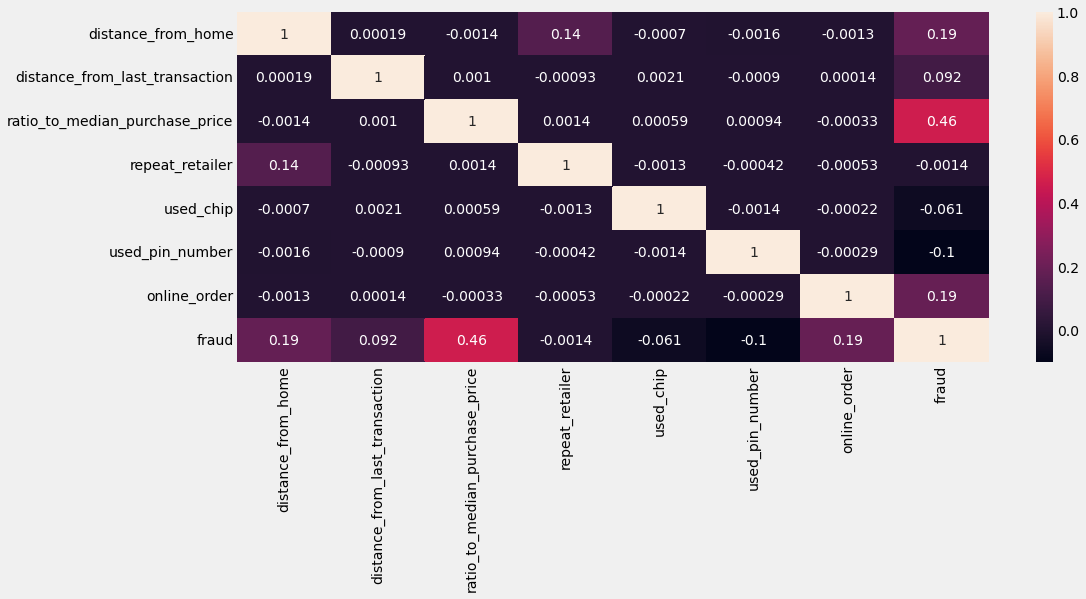

In [ ]:
plt.figure(figsize = (15,6))
sns.heatmap(df.corr(), annot=True)

Dalla matrice di correlazione in figura, notiamo una quasi assente correlazione tra quasi tutte le feature con la nostra feature di classificazione `fraud`. Tra tutte, solo `ratio_to_median_purchase_price` risulta essere correlata in modo interessante. Inoltre, come ci si aspetterebbe, seppur leggermente, `used_pin` è correlata inversamente. 
Analizziamole singolarmente.

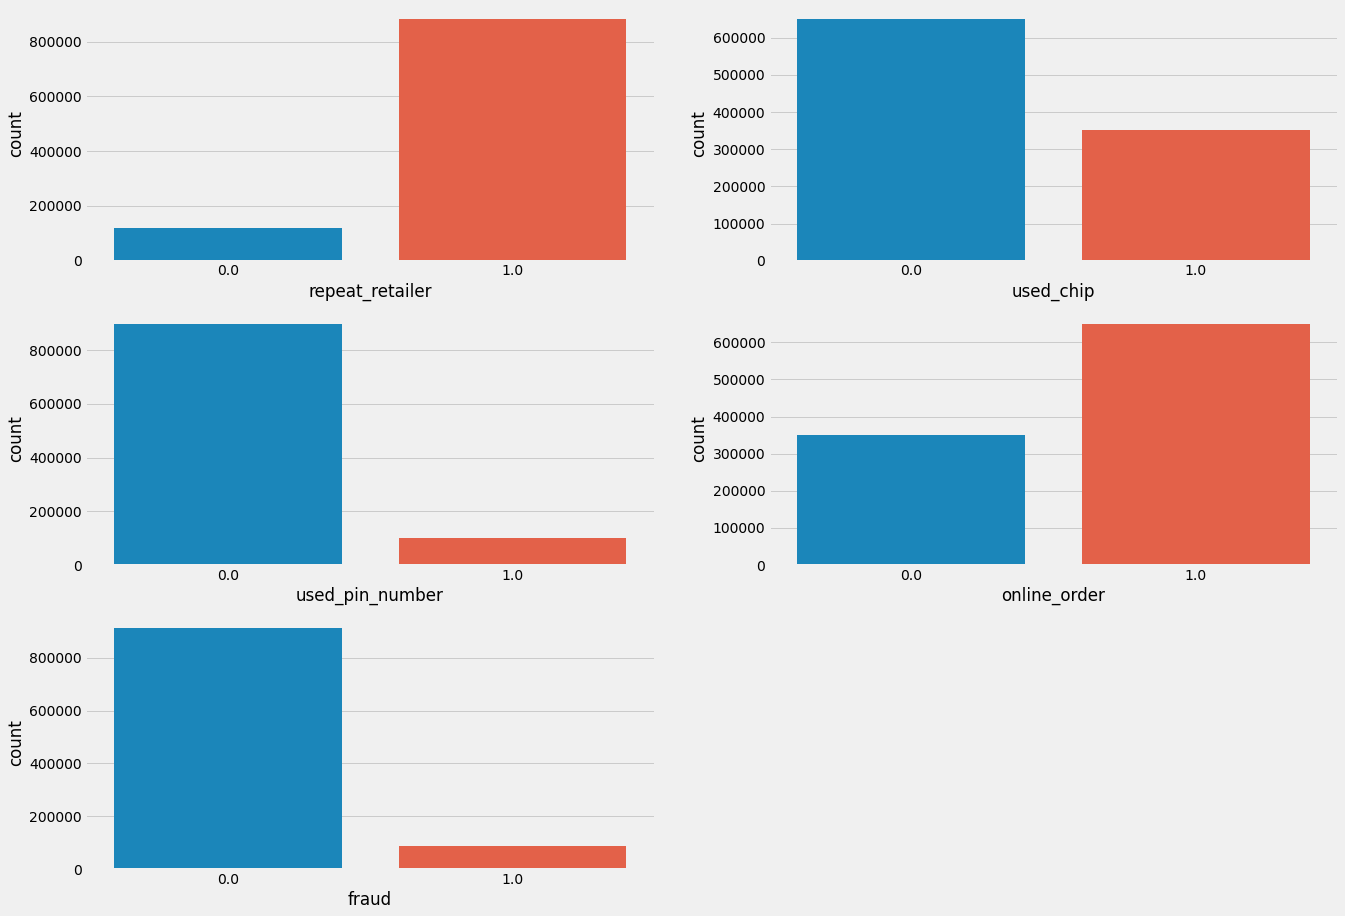

In [ ]:
plt.figure(figsize = (20,20))

plt.subplot(4,2,1)
sns.countplot(x = 'repeat_retailer', data = df)

plt.subplot(4,2,2)
sns.countplot(x = 'used_chip', data = df)

plt.subplot(4,2,3)
sns.countplot(x = 'used_pin_number', data = df)

plt.subplot(4,2,4)
sns.countplot(x = 'online_order', data = df)

plt.subplot(4,2,5)
sns.countplot(x = 'fraud', data = df)

**Variabili discrete**

* `Repeat Retailer`: La maggior parte delle transazioni sono effettuate presso lo stesso rivenditore.
* `Used Chip`: La maggior parte della transazioni non avvengono tramite carta di credito, ma queste ultime comunque costituiscono una parte importante delle transazioni.
* `Used Pin Number`: La maggior parte della transazioni avviene senza l'inserimento del codice PIN.
* `Online Order`: Ci sono più transazioni online che fisiche. 
* `Fraud`: Abbiamo poche transazioni fraudolente rispetto alle transazioni legali.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='ratio_to_median_purchase_price'>

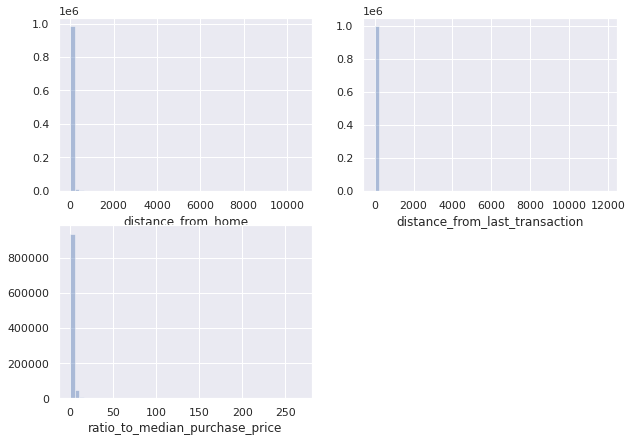

In [ ]:
plt.figure(figsize = (10,7))

sns.set(color_codes = True)

plt.subplot(2,2,1)
sns.distplot(df.distance_from_home, kde = False)

plt.subplot(2,2,2)
sns.distplot(df.distance_from_last_transaction, kde = False)

plt.subplot(2,2,3)
sns.distplot(df.ratio_to_median_purchase_price, kde = False)

**Variabili continue**

* `Distance from home`: La maggior parte della transazioni avviene vicino all'abitazione.
* `Distance from last transition`: La maggior parte della transazioni sono vicine all'ultima transazione.
* `Ratio to Median Purchase time`: La maggior parte della transazioni sono prossime all'importo medio nel tempo.

In [ ]:
labels=["Legit","Fraud"]

fraud_or_not = df["fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=df['fraud'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"], title="Fraud vs Legit transactions")
fig.show()

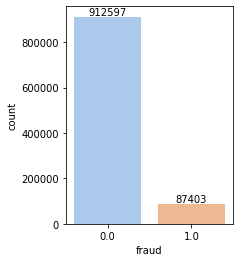

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='fraud', data=df, palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

**Sbilanciamento del dataset**

Dai grafici si evince uno rapporo tra le classi **fraud** e **legit** di circa 1 a 10. Su questa caratteristica baserò gran parte delle mie sperimentazioni.

**Utile Analisi degli Outliers**

[Text(0, 0.5, 'Feature'),
 Text(0.5, 0, 'Valori'),
 Text(0.5, 1.0, 'Boxplot delle Feature')]

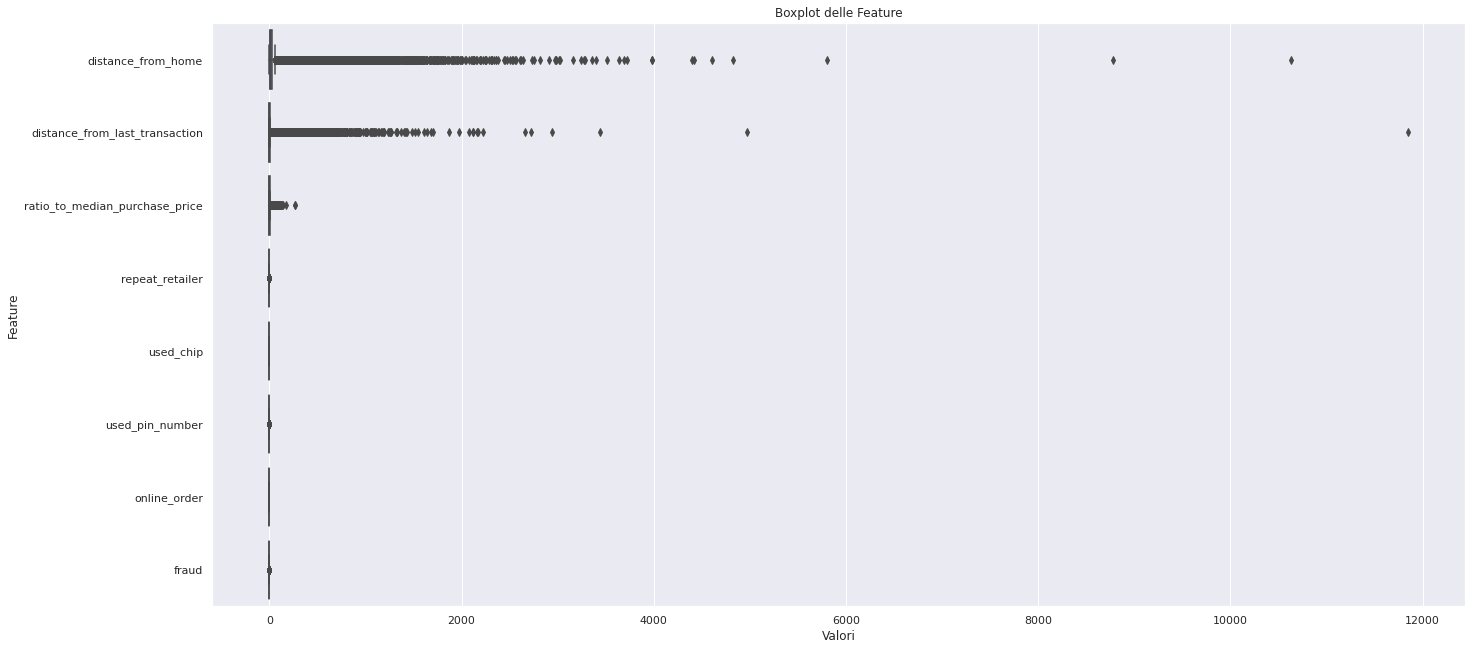

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
sea_boxplot=sns.boxplot(orient="h",data=df)
sea_boxplot.set(xlabel='Valori', ylabel='Feature', title="Boxplot delle Feature")


**Inter Quartile Range (IQR)**

Inter Quartile Range (IQR) è uno dei metodi di ritrovamento e rimozione degli outlier più utilizzato.
Proviamo ad applicarlo al nostro dataset per studiarne le conseguenze.

In [ ]:
numeric_columns = (list(df.loc[:, 'distance_from_home':'fraud']))
Outliers_IQR = IQR_method(df,1,numeric_columns)
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 87403


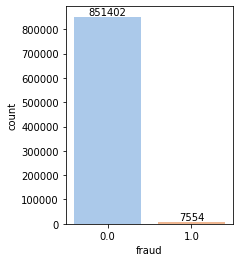

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='fraud', data=df_out, palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

Come possiamo notare, sono rimasti solo 7554 esempi di transazioni fraudolente nell'intero dataframe. Evidentemnte, su un dataframe così ampio e sbilanciato gli outliers rappresentano esattamente la classe delle transazioni fraudolente che siamo interessati a classificare, eliminando i quali accentuiamo ulteriormente lo sbilanciamento delle due classi.

Per il proseguo delle sperimentazioni, non si applicheranno procedure di eliminazione degli outliers, ma si terrà ben conto di quanto appreso da questa analisi per una oculata scelta dei metodi di scaling dei dati ed un'analisi dei risultati che sia consapevole.

**Train test splitting stratificato**

Applicare lo splitting stratificato ci permette di mantenere la stessa proporzione delle classi presenti nel dataset al momento della sua suddivisione in training e test set.

In [ ]:
X = df.drop('fraud', axis=1)
Y = df['fraud']

In [ ]:
X, x_test, Y, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.3)

**A proposito di splitting**

Come accennato nell'introduzione, in seguito si applicheranno metodi di under/over-sampling sul dataset. Pertanto ci si è chiesti se tali procedure andassero applicate prima o dopo lo splitting dei dati.

Si è deciso di applicare lo splitting del dataset prima di modificarlo in quanto farlo precedere da tecniche di under/oversampling può consentire al modello di memorizzare gli esempi specifici e causare overfitting e scarsa generalizzazione sui dati di test.

##**CONFRONTO TRA MODELLI SU DIVERSE VERSIONI DEL DATASET**

###**Creazione di una baseline** 

Questa sezione è dedicata alla sperimentazione di diversi modelli sul dataset originario

**K-Fold CV stratificata**

Poniamo la nostra attenzione sulla distribuzione delle classi di interesse.

Durante il corso, abbiamo, a più riprese, discusso di come il miglior modello non sia quello che effettua le predizioni più accurate sul training set, ma il modello che effettua buone predizioni su dati nuovi evitando overfitting e underfitting. L'obiettivo della cross-validation consiste proprio nel testare le capacità del modello su dati ad esso sconosciuti.

Ciononostante, se si esegue la cross-validation con una tecnica normale, si potrebbero generare sottoinsiemi di esempi con una particolare distribuzione delle classi, producendo punteggi di valutazione del modello eccezionalmente alti. Al fine di evitare tale situazione, creiamo sottoinsiemi stratificati che conservino la distribuzione delle classi nelle varie fold per garantire l'ottenimento di punteggi per il modello che siano significativi.

**Over/under-sample e Cross Validation**
Più avanti nel caso di studio, nelle sezioni dedicate all'over/undersampling, la cross validation sarà applicata successivamente alla creazione/rimozione degli esempi per prevenire problemi di perdita di informazioni.

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=13)

In [ ]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth = 3)

**Ottimizzare la Recall**

Durante il training dei seguenti modelli si è deciso di ottimizzare la metrica di **recall** in quanto, nell'ambito della fraud detection, così come casi ad alto rischio (e.g. sistemi medicali), l'obiettivo primario è evitare i falsi-negativi. In questo caso, un falso-negativo significa che una transazione fraudolenta viene riconosciuta come legale. Questo obiettivo merita molta più attenzione rispetto al viceversa, ovvero riconoscere come fraudolenta una transazione legale, cioè migliorando la **precision**.

In [ ]:
knn_cv_score = cross_val_score(knn, X, Y, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(knn_cv_score))
print("Average Cross Validation Recall score: {}".format(knn_cv_score.mean()))

Cross Validation Recall scores are: [0.92489376 0.92391304 0.91966329 0.92048705 0.91893438]
Average Cross Validation Recall score: 0.9215783030168876


In [ ]:
rf_cv_score = cross_val_score(rf, X, Y, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(rf_cv_score))
print("Average Cross Validation Recall score: {}".format(rf_cv_score.mean()))

Cross Validation Recall scores are: [0.99975482 0.99991827 0.99983655 1.         0.99991828]
Average Cross Validation Recall score: 0.9998855848597479


In [ ]:
xgb_cv_score = cross_val_score(xgb, X, Y, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(xgb_cv_score))
print("Average Cross Validation Recall score: {}".format(xgb_cv_score.mean()))

Cross Validation Recall scores are: [0.99689441 0.99615888 0.99256293 0.9949334  0.99517856]
Average Cross Validation Recall score: 0.9951456339987652


Esaminando i risultati della CV applicata ai tre modelli, osserviamo facilmente che, non solo otteniamo degli score alti, ma sono molto simili per ognuno dei ciqnue split. Pertanto ci aspettiamo una distribuzione delle classi, nei vari fold, altrettanto simile.

**Tuning degli Iperparametri con GridSearchCV**

In questo caso applichiamo la cross validation anche per la ricerca dei migliori iperparametri da assegnare al modello.

In [ ]:
knn_params = {
    'n_neighbors': list(range(5,10,1)),
    'metric' : ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

In [ ]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 6, 10],
    'random_state': [13]
}

In [ ]:
xgb_params = {
    'learning_rate': [0.1,0.5,0.8,1],
    'max_depth': [2,5,10],
    'n_estimators' : [50,100]
}

####**Classificatore k-NN**

In [ ]:
grid_knn = GridSearchCV(knn, param_grid=knn_params, cv=kf, scoring='recall').fit(X, Y)

In [ ]:
print('Best parameters:', grid_knn.best_params_)
print('Best score:', grid_knn.best_score_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best score: 0.9434801095066347


In [ ]:
y_pred_grid_knn = grid_knn.predict(x_test)

In [ ]:
y_pred_train_grid_knn = grid_knn.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_knn)

grid_knn_Recall = recall_score(y_test, y_pred_grid_knn)
grid_knn_Precision = precision_score(y_test, y_pred_grid_knn)
grid_knn_f1 = f1_score(y_test, y_pred_grid_knn)
grid_knn_accuracy = accuracy_score(y_test, y_pred_grid_knn)

print(cm)

[[271615   2164]
 [  1282  24939]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_grid_knn)

grid_train_knn_Recall = recall_score(Y, y_pred_train_grid_knn)
grid_train_knn_Precision = precision_score(Y, y_pred_train_grid_knn)
grid_train_knn_f1 = f1_score(Y, y_pred_train_grid_knn)
grid_train_knn_accuracy = accuracy_score(Y, y_pred_train_grid_knn)

print(cm)

[[635815   3003]
 [  1647  59535]]


In [ ]:
knn_ndf = [(grid_knn_Recall, grid_knn_Precision, grid_knn_f1, grid_knn_accuracy)]

grid_knn_score = pd.DataFrame(data=knn_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_knn_score.insert(0, 'Model', 'k-NN')
grid_knn_score

,Model,Recall,Precision,F1 Score,Accuracy
0,k-NN,0.951108,0.920156,0.935376,0.988513


In [ ]:
knn_train_ndf = [(grid_train_knn_Recall, grid_train_knn_Precision, grid_train_knn_f1, grid_train_knn_accuracy)]

grid_train_knn_score = pd.DataFrame(data=knn_train_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_knn_score.insert(0, 'Model', 'k-NN_train')
grid_train_knn_score

,Model,Recall,Precision,F1 Score,Accuracy
0,k-NN_train,0.97308,0.951981,0.962415,0.993357


Durante tutto il caso di studio i modelli saranno applicati sia sull'insieme di test che di training per verificare la presenza di overfitting.

In questo caso lo score tra le due applicazioni si discostano leggermente.

####**Random Forest**

In [ ]:
grid_rf = GridSearchCV(rf, param_grid=rf_params, cv=kf, scoring='recall').fit(X, Y)

In [ ]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 10, 'n_estimators': 100, 'random_state': 13}
Best score: 0.9998038601412024


In [ ]:
y_pred_grid_rf = grid_rf.predict(x_test)

In [ ]:
y_pred_train_grid_rf = grid_rf.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_rf)

grid_rf_Recall = recall_score(y_test, y_pred_grid_rf)
grid_rf_Precision = precision_score(y_test, y_pred_grid_rf)
grid_rf_f1 = f1_score(y_test, y_pred_grid_rf)
grid_rf_accuracy = accuracy_score(y_test, y_pred_grid_rf)

print(cm)

[[273779      0]
 [     1  26220]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_grid_rf)

grid_train_rf_Recall = recall_score(Y, y_pred_train_grid_rf)
grid_train_rf_Precision = precision_score(Y, y_pred_train_grid_rf)
grid_train_rf_f1 = f1_score(Y, y_pred_train_grid_rf)
grid_train_rf_accuracy = accuracy_score(Y, y_pred_train_grid_rf)

print(cm)

[[638818      0]
 [     0  61182]]


In [ ]:
grid_rf_ndf = [(grid_rf_Recall, grid_rf_Precision, grid_rf_f1, grid_rf_accuracy)]

grid_rf_score = pd.DataFrame(data = grid_rf_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rf_score.insert(0, 'Model', 'rf')
grid_rf_score

,Model,Recall,Precision,F1 Score,Accuracy
0,rf,0.999962,1.0,0.999981,0.999997


In [ ]:
grid_train_rf_ndf = [(grid_train_rf_Recall, grid_train_rf_Precision, grid_train_rf_f1, grid_train_rf_accuracy)]

grid_train_rf_score = pd.DataFrame(data=grid_train_rf_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_rf_score.insert(0, 'Model', 'rf_test')
grid_train_rf_score

,Model,Recall,Precision,F1 Score,Accuracy
0,rf_test,1.0,1.0,1.0,1.0


È evidente che ci troviamo davanti ad un caso di overfitting. In effetti, la toeria ci dice che l'aumento della complessità di un modello aumenta la sua capacità di adattarsi ai dati legandosi agli esempi di training fino a diventare inefficace su esempi sconosciuti. In questo caso la misura di complessità è data dalla profondità degli alberi che compongono il random forest, lunghezza stabilita "ciecamente" dal GridSearch in quanto bastosi esclusivamente sullo score della recall. 

A tal proposito, si plotta una curva di "recall vs max_depth" che mostra come varia la recall al variare della profondità.


In [ ]:
max_depths = np.arange(2, 11)
recalls = []

for max_depth in max_depths:
    clf = RandomForestClassifier(max_depth=max_depth, random_state=13)
    clf.fit(X, Y)
    y_pred_clf = clf.predict(X)
    recall_clf = recall_score(Y, y_pred_clf)
    recalls.append(recall_clf)

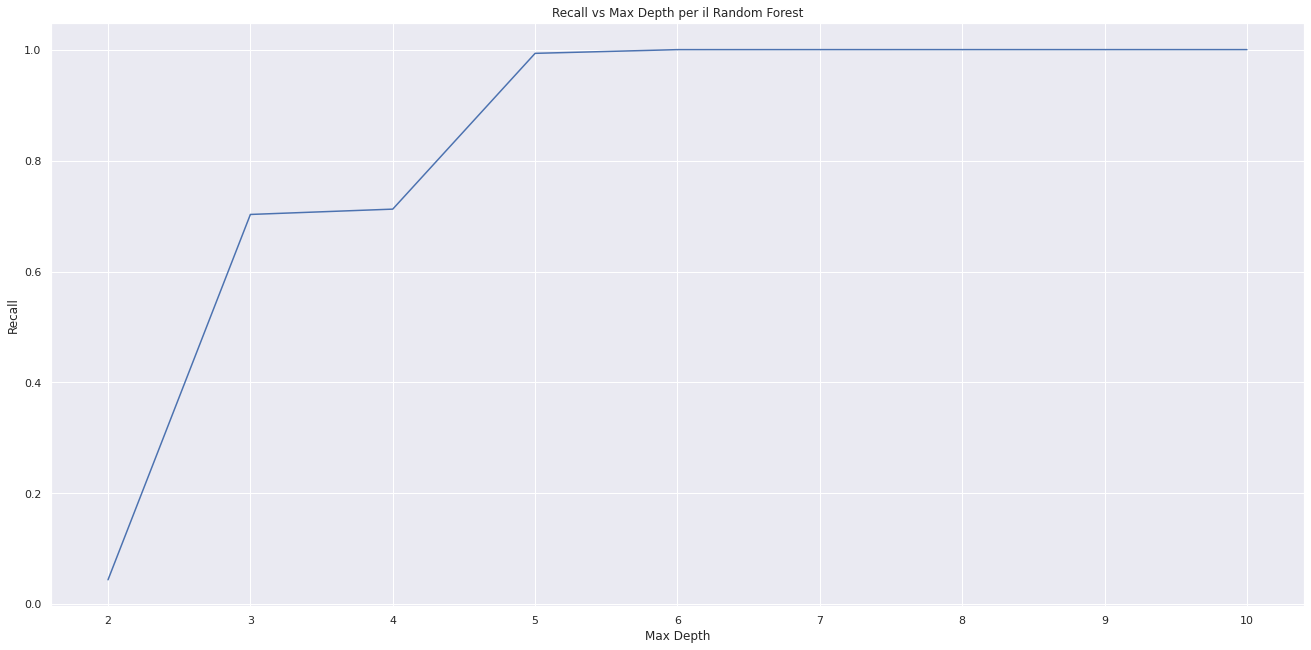

In [ ]:
plt.plot(max_depths, recalls)
plt.xlabel("Max Depth")
plt.ylabel("Recall")
plt.title("Recall vs Max Depth per il Random Forest")
plt.show()

Si consideri lo specifico RandomForest i cui alberi hanno profondità `max_depth = 3`:

In [ ]:
rf3 = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=13).fit(X,Y)

In [ ]:
y_pred_rf3 = rf3.predict(x_test)

In [ ]:
y_pred_train_rf3 = rf3.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf3)

rf3_Recall = recall_score(y_test, y_pred_rf3)
rf3_Precision = precision_score(y_test, y_pred_rf3)
rf3_f1 = f1_score(y_test, y_pred_rf3)
rf3_accuracy = accuracy_score(y_test, y_pred_rf3)

print(cm)

[[273779      0]
 [  7678  18543]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_rf3)

train_rf3_Recall = recall_score(Y, y_pred_train_rf3)
train_rf3_Precision = precision_score(Y, y_pred_train_rf3)
train_rf3_f1 = f1_score(Y, y_pred_train_rf3)
train_rf3_accuracy = accuracy_score(Y, y_pred_train_rf3)

print(cm)

[[638818      0]
 [ 18179  43003]]


In [ ]:
rf3_ndf = [(rf3_Recall, rf3_Precision, rf3_f1, rf3_accuracy)]

rf3_score = pd.DataFrame(data = rf3_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf3_score.insert(0, 'Model', 'rf')
rf3_score

,Model,Recall,Precision,F1 Score,Accuracy
0,rf,0.707181,1.0,0.828478,0.974407


In [ ]:
train_rf3_ndf = [(train_rf3_Recall, train_rf3_Precision, train_rf3_f1, train_rf3_accuracy)]

train_rf3_score = pd.DataFrame(data = train_rf3_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
train_rf3_score.insert(0, 'Model', 'rf')
train_rf3_score

,Model,Recall,Precision,F1 Score,Accuracy
0,rf,0.70287,1.0,0.825512,0.97403


Abbiamo conferma del fatto che con un `max_depth` inferiore il random forest si adatta meno agli esempi, pur riportando uno scoring identico a quello che si otterrebbe applicando lo stesso modello al set di training. Quindi anche solo con una profondità di 3 il modello va in overfitting.

####**XGBooster**

Ho è scelto di implementare il modello XGBooster per evidenziare gli effetti del boosting su un modello di ensamble learning molto simile al random forest.

XGBoost, infatti, costruisce una sequenza di modelli di base, ognuno dei quali cerca di correggere gli errori del precedente utilizzado l'algoritmo della discesa del gradiente come algoritmo di ottimizzazione per la funzione di loss.

In [ ]:
grid_xgb = GridSearchCV(xgb, param_grid=xgb_params, cv=kf, scoring='recall').fit(X, Y)

In [ ]:
print('Best parameters:', grid_xgb.best_params_)
print('Best score:', grid_xgb.best_score_)

Best parameters: {'learning_rate': 0.8, 'max_depth': 2, 'n_estimators': 100}
Best score: 0.9998202040163351


In [ ]:
y_pred_grid_xgb = grid_xgb.predict(x_test)

In [ ]:
y_pred_train_grid_xgb = grid_xgb.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_xgb)

grid_xgb_Recall = recall_score(y_test, y_pred_grid_xgb)
grid_xgb_Precision = precision_score(y_test, y_pred_grid_xgb)
grid_xgb_f1 = f1_score(y_test, y_pred_grid_xgb)
grid_xgb_accuracy = accuracy_score(y_test, y_pred_grid_xgb)

print(cm)

[[273778      1]
 [     4  26217]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_grid_xgb)

grid_train_xgb_Recall = recall_score(Y, y_pred_train_grid_xgb)
grid_train_xgb_Precision = precision_score(Y, y_pred_train_grid_xgb)
grid_train_xgb_f1 = f1_score(Y, y_pred_train_grid_xgb)
grid_train_xgb_accuracy = accuracy_score(Y, y_pred_train_grid_xgb)

print(cm)

[[638818      0]
 [     0  61182]]


In [ ]:
grid_xgb_ndf = [(grid_xgb_Recall, grid_xgb_Precision, grid_xgb_f1, grid_xgb_accuracy)]

grid_xgb_score = pd.DataFrame(data = grid_xgb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_xgb_score.insert(0, 'Model', 'xgb')
grid_xgb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgb,0.999847,0.999962,0.999905,0.999983


In [ ]:
grid_train_xgb_ndf = [(grid_train_xgb_Recall, grid_train_xgb_Precision, grid_train_xgb_f1, grid_train_xgb_accuracy)]

grid_train_xgb_score = pd.DataFrame(data=grid_train_xgb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_xgb_score.insert(0, 'Model', 'xgb_test')
grid_train_xgb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgb_test,1.0,1.0,1.0,1.0


Anche in questo caso, sia dalle matrici di confusione che dalle varie metriche, si evince che siamo in presenza di un chiaro overfitting. Possiamo però effettuare una interessante osservazione:
il modello XGBooster raggiunge il massimo overfitting con una profondità nettamente inferiore rispetto al random forest.

Come prima, si plotta una curva di "recall vs max_depth" che mostra come varia la recall al variare della profondità per il classificatore XGBooster.



In [ ]:
max_depths = np.arange(1, 6)
recalls = []

for max_depth in max_depths:
    clf = xg.XGBClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X, Y)
    y_pred_clf = clf.predict(X)
    recall_clf = recall_score(Y, y_pred_clf)
    recalls.append(recall_clf)

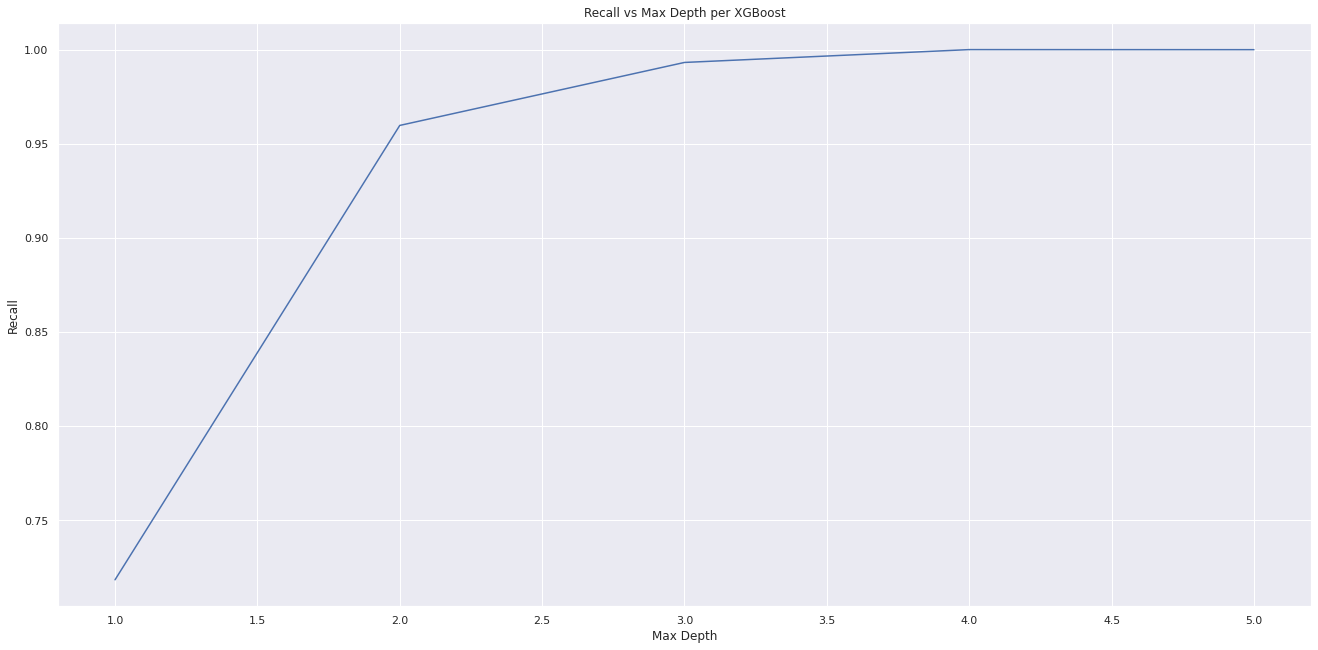

In [ ]:
plt.plot(max_depths, recalls)
plt.xlabel("Max Depth")
plt.ylabel("Recall")
plt.title("Recall vs Max Depth per XGBoost")
plt.show()

####**Confronto Performance**



In [ ]:
predictions = pd.concat([grid_knn_score, grid_rf_score, grid_xgb_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
1,rf,0.999962,1.000000,0.999981,0.999997
2,xgb,0.999847,0.999962,0.999905,0.999983
0,k-NN,0.951108,0.920156,0.935376,0.988513


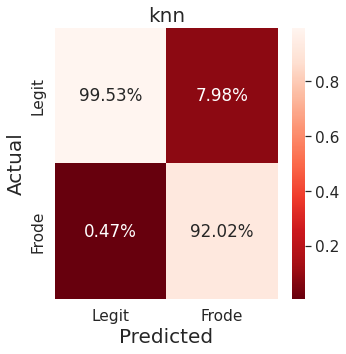

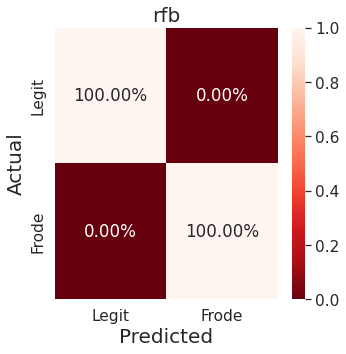

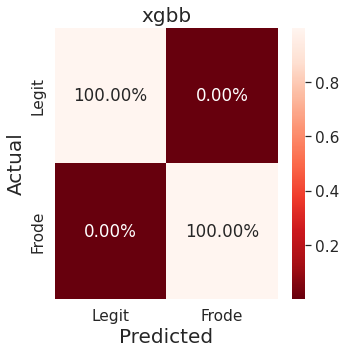

In [ ]:
confusionMatrix(y_test, y_pred_grid_knn,'knn')
confusionMatrix(y_test, y_pred_grid_rf,'rfb')
confusionMatrix(y_test, y_pred_grid_xgb,'xgbb')

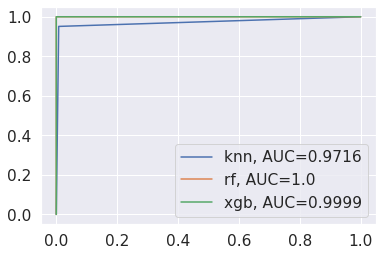

In [ ]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_knn)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_knn), 4)
plt.plot(fpr,tpr,label="knn, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_rf )
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_rf ), 4)
plt.plot(fpr,tpr,label="rf, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_xgb )
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_xgb ), 4)
plt.plot(fpr,tpr,label="xgb, AUC="+str(auc))

#add legend
plt.legend()

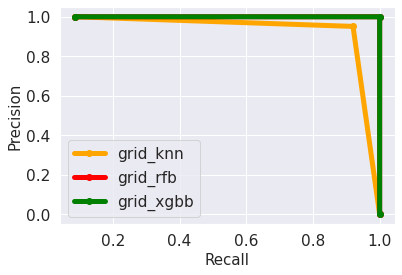

In [ ]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_knn)
plt.plot(precision, recall, marker='o', label='grid_knn',color='orange',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()


precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_rf)
plt.plot(precision, recall, marker='o', label='grid_rfb',color='red',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_xgb)
plt.plot(precision, recall, marker='o', label='grid_xgbb',color='green',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

Sia l'area sotto la curva di ROC che la curva di precisio-recall riportano grafici pressocché ideali. Tipico per modelli overfittati sui dati di trainig.

###**Assegnazione del peso alle classi**

Questa sezione è dedicata alla sperimentazione dei modelli visti nella sezione precedente sullo stesso dataset, ma le cui classi hanno peso diverso al fine di gestire lo sbilanciamento.

####**Balanced Random Forest**

La maggior parte dei modelli di machine learning prevede un parametro chiamato `class_weights` per il bilanciamento delle classi. Il random forest fa parte di questi.

In [ ]:
rfb = RandomForestClassifier(n_estimators=100, random_state=13, class_weight="balanced")

In [ ]:
grid_rfb = GridSearchCV(rfb, param_grid=rf_params, cv=kf, scoring='recall').fit(X, Y)

In [ ]:
print('Best parameters:', grid_rfb.best_params_)
print('Best score:', grid_rfb.best_score_)

Best parameters: {'max_depth': 4, 'n_estimators': 100, 'random_state': 13}
Best score: 0.9999019340777624


In [ ]:
y_pred_grid_rfb = grid_rfb.predict(x_test)

In [ ]:
y_pred_train_grid_rfb = grid_rfb.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_rfb)

grid_rfb_Recall = recall_score(y_test, y_pred_grid_rfb)
grid_rfb_Precision = precision_score(y_test, y_pred_grid_rfb)
grid_rfb_f1 = f1_score(y_test, y_pred_grid_rfb)
grid_rfb_accuracy = accuracy_score(y_test, y_pred_grid_rfb)

print(cm)

[[272627   1152]
 [     0  26221]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_grid_rfb)

grid_train_rfb_Recall = recall_score(Y, y_pred_train_grid_rfb)
grid_train_rfb_Precision = precision_score(Y, y_pred_train_grid_rfb)
grid_train_rfb_f1 = f1_score(Y, y_pred_train_grid_rfb)
grid_train_rfb_accuracy = accuracy_score(Y, y_pred_train_grid_rfb)

print(cm)

[[636094   2724]
 [     1  61181]]


In [ ]:
grid_rfb_ndf = [(grid_rfb_Recall, grid_rfb_Precision, grid_rfb_f1, grid_rfb_accuracy)]

grid_rfb_score = pd.DataFrame(data = grid_rfb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rfb_score.insert(0, 'Model', 'rfb')
grid_rfb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,rfb,1.0,0.957915,0.978505,0.99616


In [ ]:
grid_train_rfb_ndf = [(grid_train_rfb_Recall, grid_train_rfb_Precision, grid_train_rfb_f1, grid_train_rfb_accuracy)]

grid_train_rfb_score = pd.DataFrame(data=grid_train_rfb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_rfb_score.insert(0, 'Model', 'rf_train')
grid_train_rfb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,rf_train,0.999984,0.957374,0.978215,0.996107


####**Balanced k-NN**

Il classificatore k-NN per come è definito, in alcun modo viene influenzato dallo sbilanciamento del dataset.

####**Balanced XGBooster**

In questo caso, per il bilanciamento, assegno a `scale_pos_weight` un valore pari all'inverso della distribuzione delle classi. 



In [ ]:
#definire il valore di scale_pos_weight  sum(esempi negativi) / sum(esempi positivi)
legit_instances = 0
fraud_instances = 0
for i in range(0, df.shape[0]):
  if df['fraud'][i] == 0.0:
    legit_instances = legit_instances + 1
  else:
    fraud_instances = fraud_instances + 1

In [ ]:
legit_weight = fraud_instances/legit_instances
legit_weight

0.09577392868922427

In [ ]:
xgbb = xg.XGBClassifier(n_estimators=100, max_depth = 3, scale_pos_weight=legit_weight)

In [ ]:
grid_xgbb = GridSearchCV(xgbb, param_grid=xgb_params, cv=kf, scoring='recall').fit(X, Y)

In [ ]:
print('Best parameters:', grid_xgbb.best_params_)
print('Best score:', grid_xgbb.best_score_)

Best parameters: {'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 100}
Best score: 0.9997548258443629


In [ ]:
y_pred_grid_xgbb = grid_xgbb.predict(x_test)

In [ ]:
y_pred_train_grid_xgbb = grid_xgbb.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_xgbb)

grid_xgbb_Recall = recall_score(y_test, y_pred_grid_xgbb)
grid_xgbb_Precision = precision_score(y_test, y_pred_grid_xgbb)
grid_xgbb_f1 = f1_score(y_test, y_pred_grid_xgbb)
grid_xgbb_accuracy = accuracy_score(y_test, y_pred_grid_xgbb)

print(cm)

[[273779      0]
 [     3  26218]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_grid_xgbb)

grid_train_xgbb_Recall = recall_score(Y, y_pred_train_grid_xgbb)
grid_train_xgbb_Precision = precision_score(Y, y_pred_train_grid_xgbb)
grid_train_xgbb_f1 = f1_score(Y, y_pred_train_grid_xgbb)
grid_train_xgbb_accuracy = accuracy_score(Y, y_pred_train_grid_xgbb)

print(cm)

[[638818      0]
 [     1  61181]]


In [ ]:
grid_xgbb_ndf = [(grid_xgbb_Recall, grid_xgbb_Precision, grid_xgbb_f1, grid_xgbb_accuracy)]

grid_xgbb_score = pd.DataFrame(data = grid_xgbb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_xgbb_score.insert(0, 'Model', 'xgbb')
grid_xgbb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgbb,0.999886,1.0,0.999943,0.99999


In [ ]:
grid_train_xgbb_ndf = [(grid_train_xgbb_Recall, grid_train_xgbb_Precision, grid_train_xgbb_f1, grid_train_xgbb_accuracy)]

grid_train_xgbb_score = pd.DataFrame(data=grid_train_xgbb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_xgbb_score.insert(0, 'Model', 'xgbb_train')
grid_train_xgbb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgbb_train,0.999984,1.0,0.999992,0.999999


*Osservazione*: notiamo che rispetto al caso precedente, ora il classificatore XGB ha come miglior parametro `max_depth=5` e non più `max_depth=2`. Questo,ritengo, sia dovuto al fatto che ora gli errori di classificazione per le transazioni fraudolente hanno un peso maggiore rispetto a prima, di conseguenza l'algoritmo ha più difficoltà ad imparare dagli errori applicando la discesa di gradiente.

A riprova di quanto appena affermato, plottando la curva di Recall vs Max_depth per questo modello, notiamo che la curva è più smorzata rispetto alla stessa curva per il modello sui dati non bilanciati.

In [ ]:
max_depths = np.arange(1, 6)
recalls = []

for max_depth in max_depths:
    clf = xg.XGBClassifier( max_depth=max_depth, n_estimators=100, scale_pos_weight=legit_weight, random_state=42)
    clf.fit(X, Y)
    y_pred_clf = clf.predict(X)
    recall_clf = recall_score(Y, y_pred_clf)
    recalls.append(recall_clf)

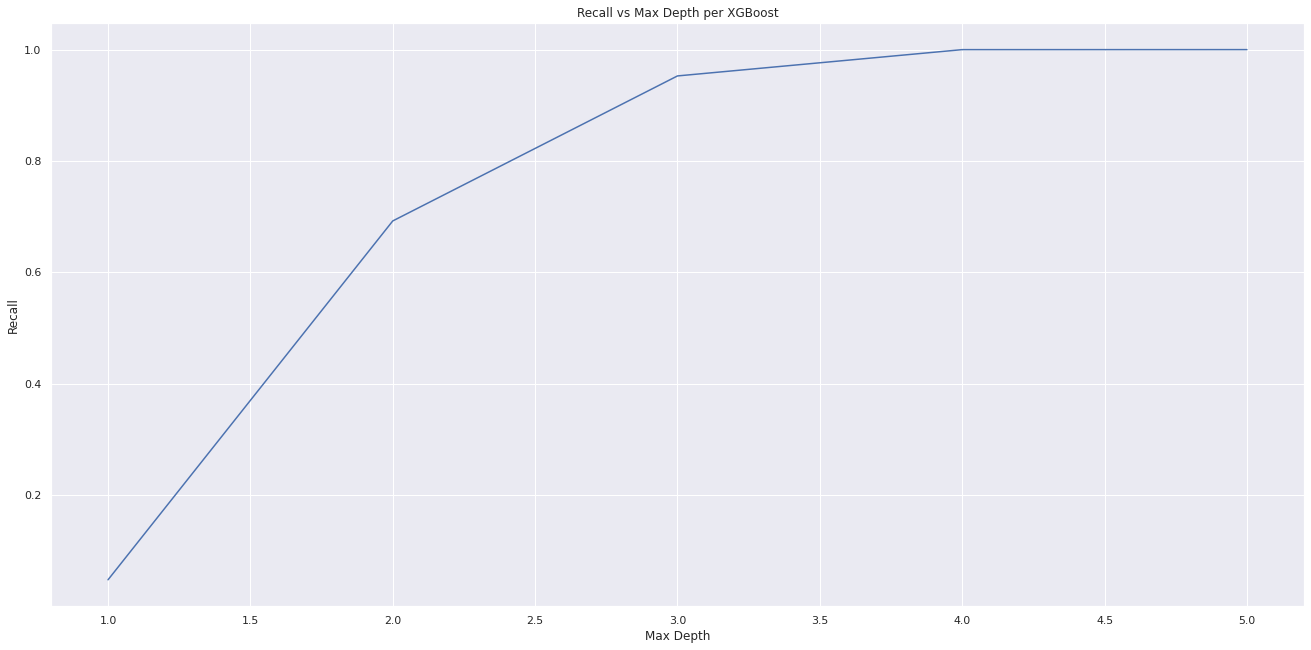

In [ ]:
plt.plot(max_depths, recalls)
plt.xlabel("Max Depth")
plt.ylabel("Recall")
plt.title("Recall vs Max Depth per XGBoost")
plt.show()

####Confronto Performance

In [ ]:
predictions = pd.concat([grid_rfb_score, grid_xgbb_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
0,rfb,0.999924,0.957072,0.978029,0.996073
1,xgbb,0.999886,1.000000,0.999943,0.999990


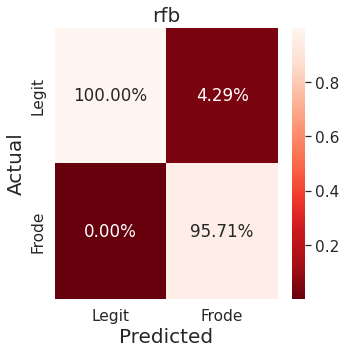

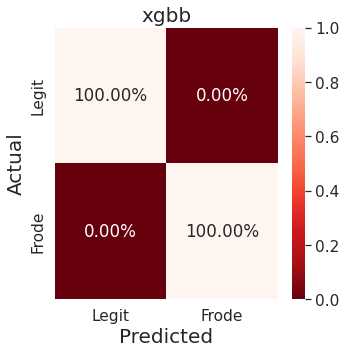

In [ ]:
confusionMatrix(y_test, y_pred_grid_rfb,'rfb')
confusionMatrix(y_test, y_pred_grid_xgbb,'xgbb')

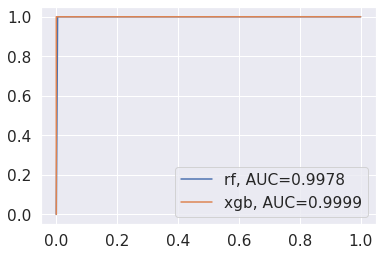

In [ ]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_rfb)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_rfb), 4)
plt.plot(fpr,tpr,label="rf, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_xgbb)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_xgbb), 4)
plt.plot(fpr,tpr,label="xgb, AUC="+str(auc))
#add legend
plt.legend()

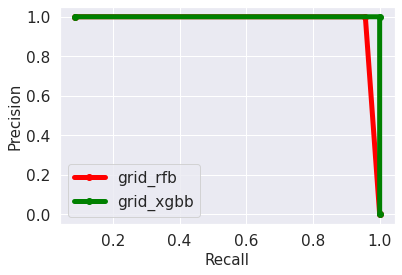

In [ ]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_rfb)
plt.plot(precision, recall, marker='o', label='grid_rfb',color='red',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_xgbb)
plt.plot(precision, recall, marker='o', label='grid_xgbb',color='green',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

Anche in questo caso, sulla base di matrici di confuzione e curve di roc e pr, possiamo dedurre che i modelli considerati, con gli iperparametri selezioni dal GridSeachCV, overfittano sui dati di training.

###**Random Undersampling Per Dataset Sbilanciati**

Dal momento che il dataset presenta un buon numero di esempi appartenenti alla classe minoritaria, è possibile provare ad applicare la tecnica del Random Undersampling, portando il numero delle transazioni legit allo stesso numero delle transazioni fraudolente. 

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

In [ ]:
X_under, Y_under = rus.fit_resample(X, Y)

In [ ]:
print('Legit:', Y_under.value_counts()[0], '/', round(Y_under.value_counts()[0]/len(Y_under) * 100,2), '% del dataset')
print('Frauds:', Y_under.value_counts()[1], '/',round(Y_under.value_counts()[1]/len(Y_under) * 100,2), '% del dataset')

Legit: 61182 / 50.0 % del dataset
Frauds: 61182 / 50.0 % del dataset


Sebbene il dataset sia stato notevolmente ridotto, restano abbastanza dati da poter provare il training dei modelli.

####K-NN sul dataset ridotto

In [ ]:
grid_knn_under = GridSearchCV(knn, param_grid=knn_params, cv=kf, scoring='recall').fit(X_under, Y_under)

In [ ]:
print('Best parameters:', grid_knn_under.best_params_)
print('Best score:', grid_knn_under.best_score_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 9}
Best score: 0.9992808334297056


Osserviamo che in questo il GridSearchCV ha selezionato `n_neighbors=9` come miglior iperparametro, differentemente da quanto accaduto per il modello di baseline in cui `n_neighbors=5`. Questo ritengo sia dovuto al fatto che essendoci un numero totale di esempi nettamente inferiore, l'algoritmo ha necessità di considerare un numero maggiore di vicini per effettuare la classificazione.

In [ ]:
y_pred_grid_knn_under = grid_knn_under.predict(x_test)

In [ ]:
y_pred_train_grid_knn_under = grid_knn_under.predict(X_under)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_knn_under)

grid_knn_under_Recall = recall_score(y_test, y_pred_grid_knn_under)
grid_knn_under_Precision = precision_score(y_test, y_pred_grid_knn_under)
grid_knn_under_f1 = f1_score(y_test, y_pred_grid_knn_under)
grid_knn_under_accuracy = accuracy_score(y_test, y_pred_grid_knn_under)

print(cm)

[[253667  20112]
 [    22  26199]]


In [ ]:
cm = confusion_matrix(Y_under, y_pred_train_grid_knn_under)

grid_train_knn_under_Recall = recall_score(Y_under, y_pred_train_grid_knn_under)
grid_train_knn_under_Precision = precision_score(Y_under, y_pred_train_grid_knn_under)
grid_train_knn_under_f1 = f1_score(Y_under, y_pred_train_grid_knn_under)
grid_train_knn_under_accuracy = accuracy_score(Y_under, y_pred_train_grid_knn_under)

print(cm)

[[57264  3918]
 [   10 61172]]


In [ ]:
grid_knn_under_ndf = [(grid_knn_under_Recall, grid_knn_under_Precision, grid_knn_under_f1, grid_knn_under_accuracy)]

grid_knn_under_score = pd.DataFrame(data=grid_knn_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_knn_under_score.insert(0, 'Model', 'grid_k-NN_under')
grid_knn_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_k-NN_under,0.999161,0.565719,0.722412,0.932887


In [ ]:
grid_train_knn_under_ndf = [(grid_train_knn_under_Recall, grid_train_knn_under_Precision, grid_train_knn_under_f1, grid_train_knn_under_accuracy)]

grid_train_knn_under_score = pd.DataFrame(data=grid_train_knn_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_knn_under_score.insert(0, 'Model', 'k-NN_train')
grid_train_knn_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,k-NN_train,0.999837,0.939806,0.968893,0.967899


I risultati ottenuti risultano essere particolarmente interessanti. Notiamo la totale assenza di overfitting, nonché un F1 score per il k-NN applicato sul test set molto inferiore rispetto al k-NN applicato sul train set. 

La recall, al contrario, si vede essere praticamente massima. Ricardando che evitare di classificare una transazione fraud come legit è il nostro primario obiettivo, un simile score di recall ci garantisce l'assenza di errore nella classificazione delle transazione fraud. 

Si tratta di un ottimo guadagno in cambio di una precision piuttosto bassa.

####Random Forest su dataset ridotto

In [ ]:
grid_rf_under = GridSearchCV(rf, param_grid=rf_params, cv=kf, scoring='recall').fit(X_under, Y_under)

In [ ]:
print('Best parameters:', grid_rf_under.best_params_)
print('Best score:', grid_rf_under.best_score_)

Best parameters: {'max_depth': 6, 'n_estimators': 100, 'random_state': 13}
Best score: 1.0


Notiamo che in questo caso `max_depth = 6` rispetto al modello di baseline in cui `max_depth = 10`. In effetti, con un calo drastico del numero di esempi, ci aspettiamo anche una minor profondità degli alberi necessaria a raggiungere l'overfitting.

In [ ]:
y_pred_grid_rf_under = grid_rf_under.predict(x_test)

In [ ]:
y_pred_train_grid_rf_under = grid_rf_under.predict(X_under)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_rf_under)

grid_rf_under_Recall = recall_score(y_test, y_pred_grid_rf_under)
grid_rf_under_Precision = precision_score(y_test, y_pred_grid_rf_under)
grid_rf_under_f1 = f1_score(y_test, y_pred_grid_rf_under)
grid_rf_under_accuracy = accuracy_score(y_test, y_pred_grid_rf_under)

print(cm)

[[272833    946]
 [     0  26221]]


In [ ]:
cm = confusion_matrix(Y_under, y_pred_train_grid_rf_under)

grid_train_rf_under_Recall = recall_score(Y_under, y_pred_train_grid_rf_under)
grid_train_rf_under_Precision = precision_score(Y_under, y_pred_train_grid_rf_under)
grid_train_rf_under_f1 = f1_score(Y_under, y_pred_train_grid_rf_under)
grid_train_rf_under_accuracy = accuracy_score(Y_under, y_pred_train_grid_rf_under)

print(cm)

[[61019   163]
 [    0 61182]]


In [ ]:
grid_rf_under_ndf = [(grid_rf_under_Recall, grid_rf_under_Precision, grid_rf_under_f1, grid_rf_under_accuracy)]

grid_rf_under_score = pd.DataFrame(data=grid_rf_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rf_under_score.insert(0, 'Model', 'grid_rf_under')
grid_rf_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_rf_under,1.0,0.965178,0.982281,0.996847


In [ ]:
grid_train_rf_under_ndf = [(grid_train_rf_under_Recall, grid_train_rf_under_Precision, grid_train_rf_under_f1, grid_train_rf_under_accuracy)]

grid_train_rf_under_score = pd.DataFrame(data=grid_train_rf_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_rf_under_score.insert(0, 'Model', 'grid_train_rf_under')
grid_train_rf_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_train_rf_under,1.0,0.997343,0.99867,0.998668


####XGB su dataset ridotto

In [ ]:
grid_xgb_under = GridSearchCV(xgb, param_grid=xgb_params, cv=kf, scoring='recall').fit(X_under, Y_under)

In [ ]:
print('Best parameters:', grid_xgb_under.best_params_)
print('Best score:', grid_xgb_under.best_score_)

Best parameters: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 100}
Best score: 0.9999509657031608


In [ ]:
y_pred_grid_xgb_under = grid_xgb_under.predict(x_test)

In [ ]:
y_pred_train_grid_xgb_under = grid_xgb_under.predict(X_under)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_xgb_under)

grid_xgb_under_Recall = recall_score(y_test, y_pred_grid_xgb_under)
grid_xgb_under_Precision = precision_score(y_test, y_pred_grid_xgb_under)
grid_xgb_under_f1 = f1_score(y_test, y_pred_grid_xgb_under)
grid_xgb_under_accuracy = accuracy_score(y_test, y_pred_grid_xgb_under)

print(cm)

[[273684     95]
 [     0  26221]]


In [ ]:
cm = confusion_matrix(Y_under, y_pred_train_grid_xgb_under)

grid_train_xgb_under_Recall = recall_score(Y_under, y_pred_train_grid_xgb_under)
grid_train_xgb_under_Precision = precision_score(Y_under, y_pred_train_grid_xgb_under)
grid_train_xgb_under_f1 = f1_score(Y_under, y_pred_train_grid_xgb_under)
grid_train_xgb_under_accuracy = accuracy_score(Y_under, y_pred_train_grid_xgb_under)

print(cm)

[[61175     7]
 [    0 61182]]


In [ ]:
grid_xgb_under_ndf = [(grid_xgb_under_Recall, grid_xgb_under_Precision, grid_xgb_under_f1, grid_xgb_under_accuracy)]

grid_xgb_under_score = pd.DataFrame(data = grid_xgb_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_xgb_under_score.insert(0, 'Model', 'xgb_under')
grid_xgb_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgb_under,1.0,0.99639,0.998192,0.999683


In [ ]:
grid_train_xgb_under_ndf = [(grid_train_xgb_under_Recall, grid_train_xgb_under_Precision, grid_train_xgb_under_f1, grid_train_xgb_under_accuracy)]

grid_train_xgb_under_score = pd.DataFrame(data=grid_train_xgb_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_xgb_under_score.insert(0, 'Model', 'xgb_train_under')
grid_train_xgb_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgb_train_under,1.0,0.999886,0.999943,0.999943


####**Confronto Performance**

In [ ]:
predictions = pd.concat([grid_knn_under_score, grid_rf_under_score, grid_xgb_under_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
1,grid_rf_under,1.000000,0.965178,0.982281,0.996847
2,xgb_under,1.000000,0.996390,0.998192,0.999683
0,grid_k-NN_under,0.999161,0.565719,0.722412,0.932887


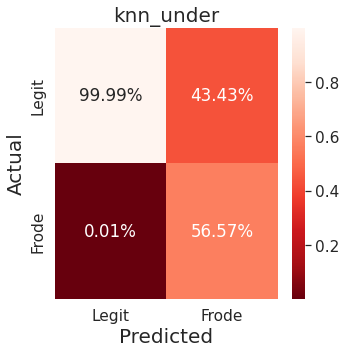

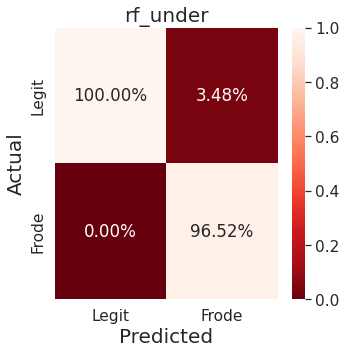

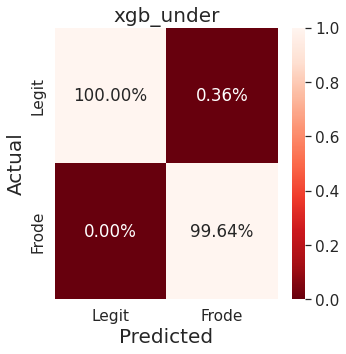

In [ ]:
confusionMatrix(y_test, y_pred_grid_knn_under,'knn_under')
confusionMatrix(y_test, y_pred_grid_rf_under,'rf_under')
confusionMatrix(y_test, y_pred_grid_xgb_under,'xgb_under')

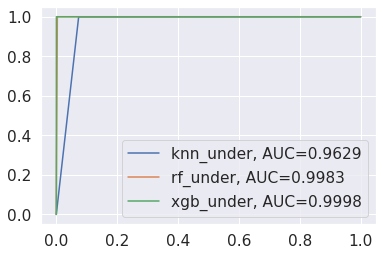

In [ ]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_knn_under)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_knn_under), 4)
plt.plot(fpr,tpr,label="knn_under, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_rf_under)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_rf_under), 4)
plt.plot(fpr,tpr,label="rf_under, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_xgb_under)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_xgb_under), 4)
plt.plot(fpr,tpr,label="xgb_under, AUC="+str(auc))
#add legend
plt.legend()

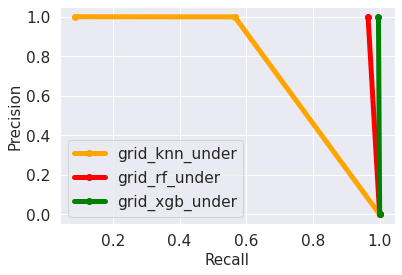

In [ ]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_knn_under)
plt.plot(precision, recall, marker='o', label='grid_knn_under',color='orange',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_rf_under)
plt.plot(precision, recall, marker='o', label='grid_rf_under',color='red',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_xgb_under)
plt.plot(precision, recall, marker='o', label='grid_xgb_under',color='green',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

Gli esiti di questa sezione riconfermano la tendenza dei modelli ad effettuare overfitting per il dataset in esame. 
Il con il comportamento migliore è il k-NN. 
Nel grafico di precisio vs recall non riesco ad interpretare le curve di random forest e xgb.

###**Random Oversampling**

Il random oversampling potrebbe aumentare la probabilità che avvenga overfitting poiché consiste nell'effettuare copie esatte di esempi appartenenti alla classe minoritaria.

In [5]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

In [ ]:
X_over, Y_over = ros.fit_resample(X, Y)

In [ ]:
print('Legit:', Y_over.value_counts()[0], '/', round(Y_over.value_counts()[0]/len(Y_over) * 100,2), '% del dataset')
print('Frauds:', Y_over.value_counts()[1], '/',round(Y_over.value_counts()[1]/len(Y_over) * 100,2), '% del dataset')

Legit: 638818 / 50.0 % del dataset
Frauds: 638818 / 50.0 % del dataset


####k-NN su dataset esteso

In [ ]:
grid_knn_over = GridSearchCV(knn, param_grid=knn_params, cv=kf, scoring='recall').fit(X_over, Y_over)

In [ ]:
print('Best parameters:', grid_knn_over.best_params_)
print('Best score:', grid_knn_over.best_score_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best score: 0.9999577344383443


In [ ]:
y_pred_grid_knn_over = grid_knn_over.predict(x_test)

In [ ]:
y_pred_train_grid_knn_over = grid_knn_over.predict(X_over)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_knn_over)

grid_knn_over_Recall = recall_score(y_test, y_pred_grid_knn_over)
grid_knn_over_Precision = precision_score(y_test, y_pred_grid_knn_over)
grid_knn_over_f1 = f1_score(y_test, y_pred_grid_knn_over)
grid_knn_over_accuracy = accuracy_score(y_test, y_pred_grid_knn_over)

print(cm)

[[267585   6194]
 [   238  25983]]


In [ ]:
cm = confusion_matrix(Y_over, y_pred_train_grid_knn_over)

grid_train_knn_over_Recall = recall_score(Y_over, y_pred_train_grid_knn_over)
grid_train_knn_over_Precision = precision_score(Y_over, y_pred_train_grid_knn_over)
grid_train_knn_over_f1 = f1_score(Y_over, y_pred_train_grid_knn_over)
grid_train_knn_over_accuracy = accuracy_score(Y_over, y_pred_train_grid_knn_over)

print(cm)

[[628358  10460]
 [     2 638816]]


In [ ]:
grid_knn_over_ndf = [(grid_knn_over_Recall, grid_knn_over_Precision, grid_knn_over_f1, grid_knn_over_accuracy)]

grid_knn_over_score = pd.DataFrame(data=grid_knn_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_knn_over_score.insert(0, 'Model', 'grid_k-NN_over')
grid_knn_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_k-NN_over,0.990923,0.807502,0.889859,0.97856


In [ ]:
grid_train_knn_over_ndf = [(grid_train_knn_over_Recall, grid_train_knn_over_Precision, grid_train_knn_over_f1, grid_train_knn_over_accuracy)]

grid_train_knn_over_score = pd.DataFrame(data=grid_train_knn_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_knn_over_score.insert(0, 'Model', 'grid_k-NN_over_train')
grid_train_knn_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_k-NN_over_train,0.999997,0.98389,0.991878,0.991811


Anche in questo caso valgono le considerazioni effettuate per il k-NN con undersampling. 

####Random Forest su dataset esteso

In [ ]:
grid_rf_over = GridSearchCV(rf, param_grid=rf_params, cv=kf, scoring='recall').fit(X_over, Y_over)

In [ ]:
print('Best parameters:', grid_rf_over.best_params_)
print('Best score:', grid_rf_over.best_score_)

Best parameters: {'max_depth': 6, 'n_estimators': 50, 'random_state': 13}
Best score: 1.0


In [ ]:
y_pred_grid_rf_over = grid_rf_over.predict(x_test)

In [ ]:
y_pred_train_grid_rf_over = grid_rf_over.predict(X_over)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_rf_over)

grid_rf_over_Recall = recall_score(y_test, y_pred_grid_rf_over)
grid_rf_over_Precision = precision_score(y_test, y_pred_grid_rf_over)
grid_rf_over_f1 = f1_score(y_test, y_pred_grid_rf_over)
grid_rf_over_accuracy = accuracy_score(y_test, y_pred_grid_rf_over)

print(cm)

[[273767     12]
 [     1  26220]]


In [ ]:
cm = confusion_matrix(Y_over, y_pred_train_grid_rf_over)

grid_train_rf_over_Recall = recall_score(Y_over, y_pred_train_grid_rf_over)
grid_train_rf_over_Precision = precision_score(Y_over, y_pred_train_grid_rf_over)
grid_train_rf_over_f1 = f1_score(Y_over, y_pred_train_grid_rf_over)
grid_train_rf_over_accuracy = accuracy_score(Y_over, y_pred_train_grid_rf_over)

print(cm)

[[638783     35]
 [     0 638818]]


In [ ]:
grid_rf_over_ndf = [(grid_rf_over_Recall, grid_rf_over_Precision, grid_rf_over_f1, grid_rf_over_accuracy)]

grid_rf_over_score = pd.DataFrame(data=grid_rf_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rf_over_score.insert(0, 'Model', 'grid_rf_over')
grid_rf_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_rf_over,0.999962,0.999543,0.999752,0.999957


In [ ]:
grid_train_rf_over_ndf = [(grid_train_rf_over_Recall, grid_train_rf_over_Precision, grid_train_rf_over_f1, grid_train_rf_over_accuracy)]

grid_train_rf_over_score = pd.DataFrame(data=grid_train_rf_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_rf_over_score.insert(0, 'Model', 'grid_train_rf_over')
grid_train_rf_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_train_rf_over,1.0,0.999945,0.999973,0.999973


####XGB su dataset esteso

In [ ]:
grid_xgb_over = GridSearchCV(xgb, param_grid=xgb_params, cv=kf, scoring='recall').fit(X_over, Y_over)

In [ ]:
print('Best parameters:', grid_xgb_over.best_params_)
print('Best score:', grid_xgb_over.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best score: 1.0


In [ ]:
y_pred_grid_xgb_over = grid_xgb_over.predict(x_test)

In [ ]:
y_pred_train_grid_xgb_over = grid_xgb_over.predict(X_over)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_xgb_over)

grid_xgb_over_Recall = recall_score(y_test, y_pred_grid_xgb_over)
grid_xgb_over_Precision = precision_score(y_test, y_pred_grid_xgb_over)
grid_xgb_over_f1 = f1_score(y_test, y_pred_grid_xgb_over)
grid_xgb_over_accuracy = accuracy_score(y_test, y_pred_grid_xgb_over)

print(cm)

[[273777      2]
 [     4  26217]]


In [ ]:
cm = confusion_matrix(Y_over, y_pred_train_grid_xgb_over)

grid_train_xgb_over_Recall = recall_score(Y_over, y_pred_train_grid_xgb_over)
grid_train_xgb_over_Precision = precision_score(Y_over, y_pred_train_grid_xgb_over)
grid_train_xgb_over_f1 = f1_score(Y_over, y_pred_train_grid_xgb_over)
grid_train_xgb_over_accuracy = accuracy_score(Y_over, y_pred_train_grid_xgb_over)

print(cm)

[[638818      0]
 [     0 638818]]


In [ ]:
grid_xgb_over_ndf = [(grid_xgb_over_Recall, grid_xgb_over_Precision, grid_xgb_over_f1, grid_xgb_over_accuracy)]

grid_xgb_over_score = pd.DataFrame(data=grid_xgb_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_xgb_over_score.insert(0, 'Model', 'grid_xgb_over')
grid_xgb_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_xgb_over,0.999847,0.999924,0.999886,0.99998


In [ ]:
grid_train_xgb_over_ndf = [(grid_train_xgb_over_Recall, grid_train_xgb_over_Precision, grid_train_xgb_over_f1, grid_train_xgb_over_accuracy)]

grid_train_xgb_over_score = pd.DataFrame(data=grid_train_xgb_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_xgb_over_score.insert(0, 'Model', 'grid_train_xgb_over')
grid_train_xgb_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_train_xgb_over,1.0,1.0,1.0,1.0


####**Confronto Performance**

In [ ]:
predictions = pd.concat([grid_knn_over_score, grid_rf_over_score, grid_xgb_over_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
1,grid_rf_over,0.999962,0.999543,0.999752,0.999957
2,grid_xgb_over,0.999847,0.999924,0.999886,0.999980
0,grid_k-NN_over,0.990923,0.807502,0.889859,0.978560


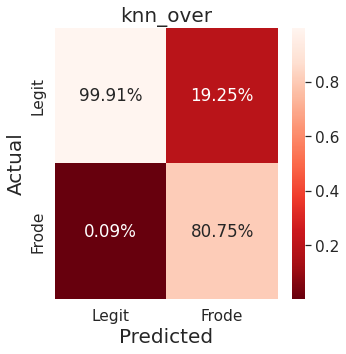

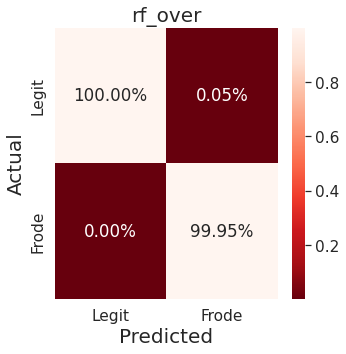

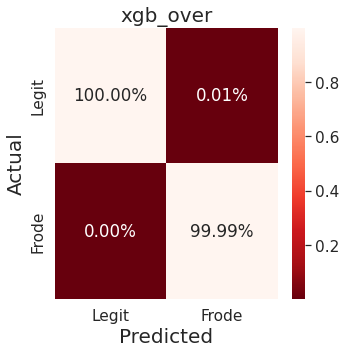

In [ ]:
confusionMatrix(y_test, y_pred_grid_knn_over,'knn_over')
confusionMatrix(y_test, y_pred_grid_rf_over,'rf_over')
confusionMatrix(y_test, y_pred_grid_xgb_over,'xgb_over')

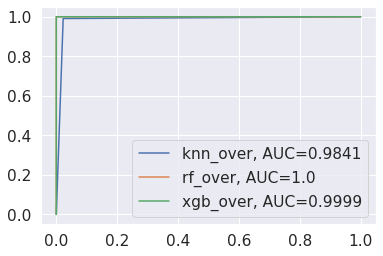

In [ ]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_knn_over)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_knn_over), 4)
plt.plot(fpr,tpr,label="knn_over, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_rf_over)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_rf_over), 4)
plt.plot(fpr,tpr,label="rf_over, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_xgb_over)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_xgb_over), 4)
plt.plot(fpr,tpr,label="xgb_over, AUC="+str(auc))
#add legend
plt.legend()

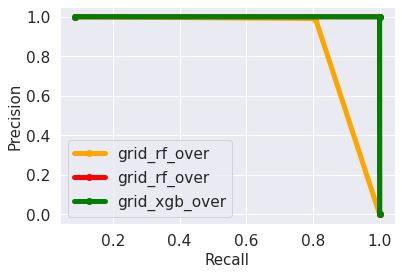

In [ ]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_knn_over)
plt.plot(precision, recall, marker='o', label='grid_knn_over',color='orange',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_rf_over)
plt.plot(precision, recall, marker='o', label='grid_rf_over',color='red',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_xgb_over)
plt.plot(precision, recall, marker='o', label='grid_xgb_over',color='green',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

Nuovamente, il k-NN dimostra avere il comportamento migliore tra i vari modelli testati. Per i modelli restanti si riconfermano le considerazioni effettuate nella sezione precedente.

###**Conclusioni**
L'applicazione del GreadSearchCV ha comportato la selezione di iperparametri tali da portare i modelli al sovradattamento. 
Questo non ha permesso di notare in maniera evidente l'efficacia del gradient descent nel modello XGBooster.
Generalmente il k-NN ha presentato un tasso false positive piuttosto alto (circa il 20%) a favore di un tasso true-positive dell'80%, che, come detto, rispecchia il principale obiettivo di questo caso di studio.

##**APPRENDIMENTO PROBABILISTICO E FEATURE SCALING**

In questa sezione si applicherà il classificatore **Naive Bayes** prima sul dataset originale al fine di creare una baseline di riferimento, in seguito, si utilizzerano i metodi di scaling dei dati _StandardScaler_ e _RobustScaler_ al fine di verificare eventuali migliorie nella classificazione.

Lo scaling è una tecnica utilizzata nel preprocessing dei dati per normalizzare i valori delle feature di un dataset all'interno di intervallo comune, tipicamente tra 0 e 1.

Il classificatore Naive Bayes non è sensibile alla scala delle feature come alcuni altri algoritmi (e.g. k-NN), ciononostante lo scaling dei dati può ancora avere un impatto sulle prestazioni dell'algoritmo in diversi modi:

- Importanza delle feature: Se le feature sono definite su range di valori o unità di misura differenti, alcune feature potrebbero dominare sulle altre e deviare i risultati. Lo scaling dei dati aiuta a garantire che le feature abbiano un impatto simile sulle probabilità, migliorando le prestazioni dell'algoritmo.

- Overfitting: Feature definite su range o unità di misura differenti aumentano la complessità del modello favorendone l'overfitting. Lo scaling dei dati può aiutare a ridurre il rischio di overfitting riducendo la complessità del modello.





**Feature scaling**

Quali risultati ci aspettiamo?

Lo StandardScaler ed il RobustScaler sono due metodi di scaler differenti. 

Il primo usa la media e la deviazione standard delle feature per ridimensionare i dati, assumendo che gli esempi seguano una distribuzione normale e presentando una certa sensibilità agli outliers. 

Il RobustScaler utilizza la mediana e il quartile invece della media e della deviazione standard per calcolare la scala dei dati. Ciò lo rende più resistente ai valori anomali o fuori scala (chiamati anche "outlier") che potrebbero influire sulle prestazioni di alcuni algoritmi di apprendimento automatico.
Il robust scaler è particolarmente utile quando si lavora con dati che contengono molti valori anomali o fuori scala. In questi casi, la deviazione standard potrebbe non essere una rappresentazione accurata della scala dei dati, e utilizzare la mediana e il quartile per la normalizzazione può dare risultati migliori.

Dal momento che per il nostro dataset gli outliers rappresentano in realtà la quasi totalità degli esempi da classificare, ci si può aspettare che metodi più sensibili ai valori anomali aiutino a raggiungere una classificazione migliore.

###**Creazione di una baseline per il confronto**

In [ ]:
X = df.drop('fraud', axis=1)
Y = df['fraud']

In [ ]:
X, x_test, Y, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.3)

In [ ]:
nb = GaussianNB().fit(X,Y)

In [ ]:
y_pred_nb = nb.predict(x_test)

In [ ]:
y_pred_train_nb = nb.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_nb)

nb_Recall = recall_score(y_test, y_pred_nb)
nb_Precision = precision_score(y_test, y_pred_nb)
nb_f1 = f1_score(y_test, y_pred_nb)
nb_accuracy = accuracy_score(y_test, y_pred_nb)

print(cm)

[[269617   4162]
 [ 10906  15315]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_nb)

nb_train_Recall = recall_score(Y, y_pred_train_nb)
nb_train_Precision = precision_score(Y, y_pred_train_nb)
nb_train_f1 = f1_score(Y, y_pred_train_nb)
nb_train_accuracy = accuracy_score(Y, y_pred_train_nb)

print(cm)

[[629256   9562]
 [ 24951  36231]]


In [ ]:
nb_ndf = [(nb_Recall, nb_Precision, nb_f1, nb_accuracy)]

nb_score = pd.DataFrame(data=nb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
nb_score.insert(0, 'Model', 'nb')
nb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,nb,0.584074,0.786312,0.67027,0.949773


In [ ]:
nb_train_ndf = [(nb_train_Recall, nb_train_Precision, nb_train_f1, nb_train_accuracy)]

nb_train_score = pd.DataFrame(data=nb_train_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
nb_train_score.insert(0, 'Model', 'nb_train')
nb_train_score

,Model,Recall,Precision,F1 Score,Accuracy
0,nb_train,0.592184,0.791191,0.677373,0.950696


###**Standard Scaler**

In [ ]:
X = df.drop('fraud', axis=1)
Y = df['fraud']

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
X_standard = scaler.fit_transform(X)

In [ ]:
X_standard[0]

array([ 0.47788202, -0.18284892,  0.04349141,  0.36658372,  1.36157608,
       -0.33445812, -1.36442519])

In [ ]:
X_standard, x_test_standard, Y_standard, y_test_standard = train_test_split(X_standard, Y, stratify=Y, test_size = 0.3)

####Training di Naive Bayes con Standard Scaler

In [ ]:
nbs = GaussianNB().fit(X_standard, Y_standard)

In [ ]:
y_pred_nbs = nbs.predict(x_test_standard)

In [ ]:
y_pred_train_nbs = nbs.predict(X_standard)

In [ ]:
cm = confusion_matrix(y_test_standard, y_pred_nbs)

nbs_Recall = recall_score(y_test_standard, y_pred_nbs)
nbs_Precision = precision_score(y_test_standard, y_pred_nbs)
nbs_f1 = f1_score(y_test_standard, y_pred_nbs)
nbs_accuracy = accuracy_score(y_test_standard, y_pred_nbs)

print(cm)

[[268982   4797]
 [ 11211  15010]]


In [ ]:
cm = confusion_matrix(Y_standard, y_pred_train_nbs)

nbs_train_Recall = recall_score(Y_standard, y_pred_train_nbs)
nbs_train_Precision = precision_score(Y_standard, y_pred_train_nbs)
nbs_train_f1 = f1_score(Y_standard, y_pred_train_nbs)
nbs_train_accuracy = accuracy_score(Y_standard, y_pred_train_nbs)

print(cm)

[[627854  10964]
 [ 26299  34883]]


In [ ]:
nbs_ndf = [(nbs_Recall, nbs_Precision, nbs_f1, nbs_accuracy)]

nbs_score = pd.DataFrame(data=nbs_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
nbs_score.insert(0, 'Model', 'nbs')
nbs_score

,Model,Recall,Precision,F1 Score,Accuracy
0,nbs,0.572442,0.757813,0.652212,0.94664


In [ ]:
nbs_train_ndf = [(nbs_train_Recall, nbs_train_Precision, nbs_train_f1, nbs_train_accuracy)]

nbs_train_score = pd.DataFrame(data=nbs_train_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
nbs_train_score.insert(0, 'Model', 'nbs_train')
nbs_train_score

,Model,Recall,Precision,F1 Score,Accuracy
0,nbs_train,0.570151,0.760857,0.651842,0.946767


###**Robust Scaler**

In [ ]:
X = df.drop('fraud', axis=1)
Y = df['fraud']

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
scaler = RobustScaler()

In [ ]:
X_robust = scaler.fit_transform(X)

In [ ]:
X_robust[0]

array([ 2.19107961, -0.2247443 ,  0.58507116,  0.        ,  1.        ,
        0.        , -1.        ])

In [ ]:
X_robust, x_test_robust, Y_robust, y_test_robust = train_test_split(X_robust, Y, stratify=Y, test_size = 0.3)

####Training di Naive Bayes con Robust Scaler

In [ ]:
nbr = GaussianNB().fit(X_robust, Y_robust)

In [ ]:
y_pred_nbr = nbr.predict(x_test_robust)

In [ ]:
y_pred_train_nbr = nbr.predict(X_robust)

In [ ]:
cm = confusion_matrix(y_test_robust, y_pred_nbr)

nbr_Recall = recall_score(y_test_robust, y_pred_nbr)
nbr_Precision = precision_score(y_test_robust, y_pred_nbr)
nbr_f1 = f1_score(y_test_robust, y_pred_nbr)
nbr_accuracy = accuracy_score(y_test_robust, y_pred_nbr)

print(cm)

[[269191   4588]
 [ 10792  15429]]


In [ ]:
cm = confusion_matrix(Y_robust, y_pred_train_nbr)

nbr_train_Recall = recall_score(Y_robust, y_pred_train_nbr)
nbr_train_Precision = precision_score(Y_robust, y_pred_train_nbr)
nbr_train_f1 = f1_score(Y_robust, y_pred_train_nbr)
nbr_train_accuracy = accuracy_score(Y_robust, y_pred_train_nbr)

print(cm)

[[628014  10804]
 [ 25347  35835]]


In [ ]:
nbr_ndf = [(nbr_Recall, nbr_Precision, nbr_f1, nbr_accuracy)]

nbr_score = pd.DataFrame(data=nbr_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
nbr_score.insert(0, 'Model', 'nbr')
nbr_score

,Model,Recall,Precision,F1 Score,Accuracy
0,nbr,0.588421,0.770795,0.667373,0.948733


In [ ]:
nbr_train_ndf = [(nbr_train_Recall, nbr_train_Precision, nbr_train_f1, nbr_train_accuracy)]

nbr_train_score = pd.DataFrame(data=nbr_train_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
nbr_train_score.insert(0, 'Model', 'nbr_train')
nbr_train_score

,Model,Recall,Precision,F1 Score,Accuracy
0,nbr_train,0.585711,0.768348,0.664713,0.948356


###**Confronto Performance**

In [ ]:
predictions = pd.concat([nb_score, nbs_score, nbr_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
2,nbr,0.588421,0.770795,0.667373,0.948733
0,nb,0.584074,0.786312,0.670270,0.949773
1,nbs,0.572442,0.757813,0.652212,0.946640


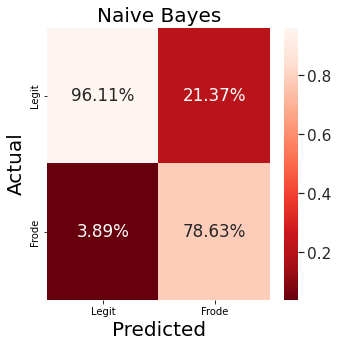

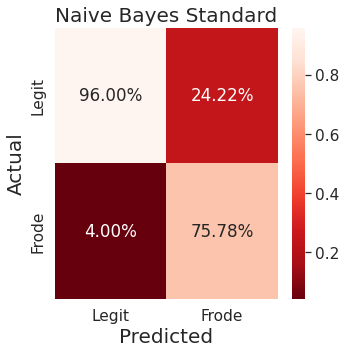

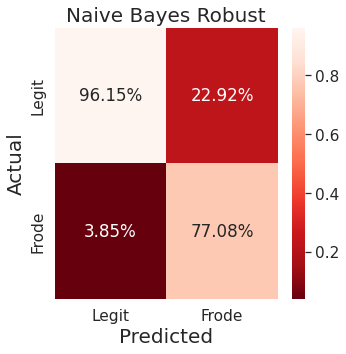

In [ ]:
confusionMatrix(y_test, y_pred_nb,'Naive Bayes')
confusionMatrix(y_test_standard, y_pred_nbs,'Naive Bayes Standard')
confusionMatrix(y_test_robust, y_pred_nbr,'Naive Bayes Robust')

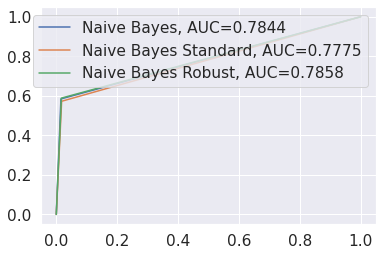

In [ ]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_nb)
auc = round(metrics.roc_auc_score(y_test, y_pred_nb), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_standard, y_pred_nbs)
auc = round(metrics.roc_auc_score(y_test_standard, y_pred_nbs), 4)
plt.plot(fpr,tpr,label="Naive Bayes Standard, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_robust, y_pred_nbr)
auc = round(metrics.roc_auc_score(y_test_robust, y_pred_nbr), 4)
plt.plot(fpr,tpr,label="Naive Bayes Robust, AUC="+str(auc))

plt.legend()

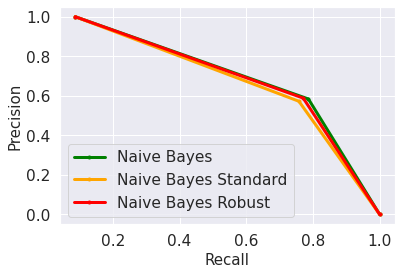

In [ ]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_nb)
plt.plot(precision, recall, marker='.', label='Naive Bayes',color='green',linewidth=3)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test_standard, y_pred_nbs)
plt.plot(precision, recall, marker='.', label='Naive Bayes Standard',color='orange',linewidth=3)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test_robust, y_pred_nbr)
plt.plot(precision, recall, marker='.', label='Naive Bayes Robust',color='red',linewidth=3)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

###**Conclusioni**
Dalle metriche si evince che, per il dataset in questione, il modello Naive Bayes presenta un buon true positive rate in tutte e tre i casi. Sicuramente preferibile ad un classificatore randomico.

Inoltre, in merito allo scaling dei dati, non lo solo lo scaling non ha apportato migliorie nella predizione, ma addirittura il Naive Bayes ha perfornmato il comportamento migliore. 
Suppongo che, normalizzando i dati si siano perse delle caratteristiche nei dati che favoriscono la classificazione delle transazioni fraudolente.

##**LA FEATURE SELECTION APPLICATA AL DECISION TREE**

La bassa correlazione tra le feature del dataset in esame ci permette di sperimetnare quanto la feature selection influisce sul modello **Decision Tree**, ovvero un modello che per certi versi effettua una feature selection intrinseca basando la scelta della feature di split sulla massimizzazione dell'**information gain**.

Per questo motivo ci si aspetta che le prestazioni del modello siano simili sia pre che post feature selection.

In [ ]:
from sklearn import tree

In [ ]:
X = df.drop('fraud', axis=1)
Y = df['fraud']

In [ ]:
X, x_test, Y, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.3)

Controlliamo come varia la Recall al variare dell'iperparametro `max_depth`:

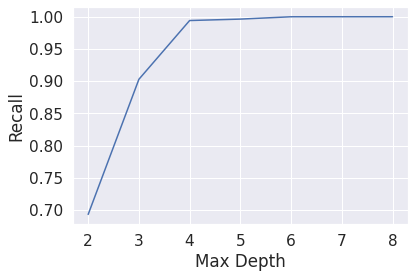

In [ ]:
max_depth_range = np.arange(2, 9)
recall_scores = []

for max_depth in max_depth_range:
    dt = tree.DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X, Y)

    y_pred_dt = dt.predict(x_test)
    recall = recall_score(y_test, y_pred_dt)
    recall_scores.append(recall)

plt.plot(max_depth_range, recall_scores)
plt.xlabel('Max Depth')
plt.ylabel('Recall')
plt.show()

Per la sperimentazione che segue si considerino alberi con `max_depth=3` come giusto compromesso tra recall e complessità del modello.

In [ ]:
dt = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=3).fit(X, Y)

[Text(0.5, 0.875, 'X[2] <= 4.0\nentropy = 0.428\nsamples = 700000\nvalue = [638818, 61182]\nclass = legit'),
 Text(0.25, 0.625, 'X[0] <= 100.016\nentropy = 0.169\nsamples = 627853\nvalue = [612158, 15695]\nclass = legit'),
 Text(0.125, 0.375, 'X[1] <= 50.001\nentropy = 0.052\nsamples = 596517\nvalue = [593031, 3486]\nclass = legit'),
 Text(0.0625, 0.125, 'entropy = 0.0\nsamples = 587754\nvalue = [587754, 0]\nclass = legit'),
 Text(0.1875, 0.125, 'entropy = 0.97\nsamples = 8763\nvalue = [5277, 3486]\nclass = legit'),
 Text(0.375, 0.375, 'X[6] <= 0.5\nentropy = 0.965\nsamples = 31336\nvalue = [19127, 12209]\nclass = legit'),
 Text(0.3125, 0.125, 'entropy = 0.101\nsamples = 10985\nvalue = [10840, 145]\nclass = legit'),
 Text(0.4375, 0.125, 'entropy = 0.975\nsamples = 20351\nvalue = [8287, 12064]\nclass = fraud'),
 Text(0.75, 0.625, 'X[6] <= 0.5\nentropy = 0.95\nsamples = 72147\nvalue = [26660, 45487]\nclass = fraud'),
 Text(0.625, 0.375, 'X[0] <= 1.9\nentropy = 0.546\nsamples = 25356\nval

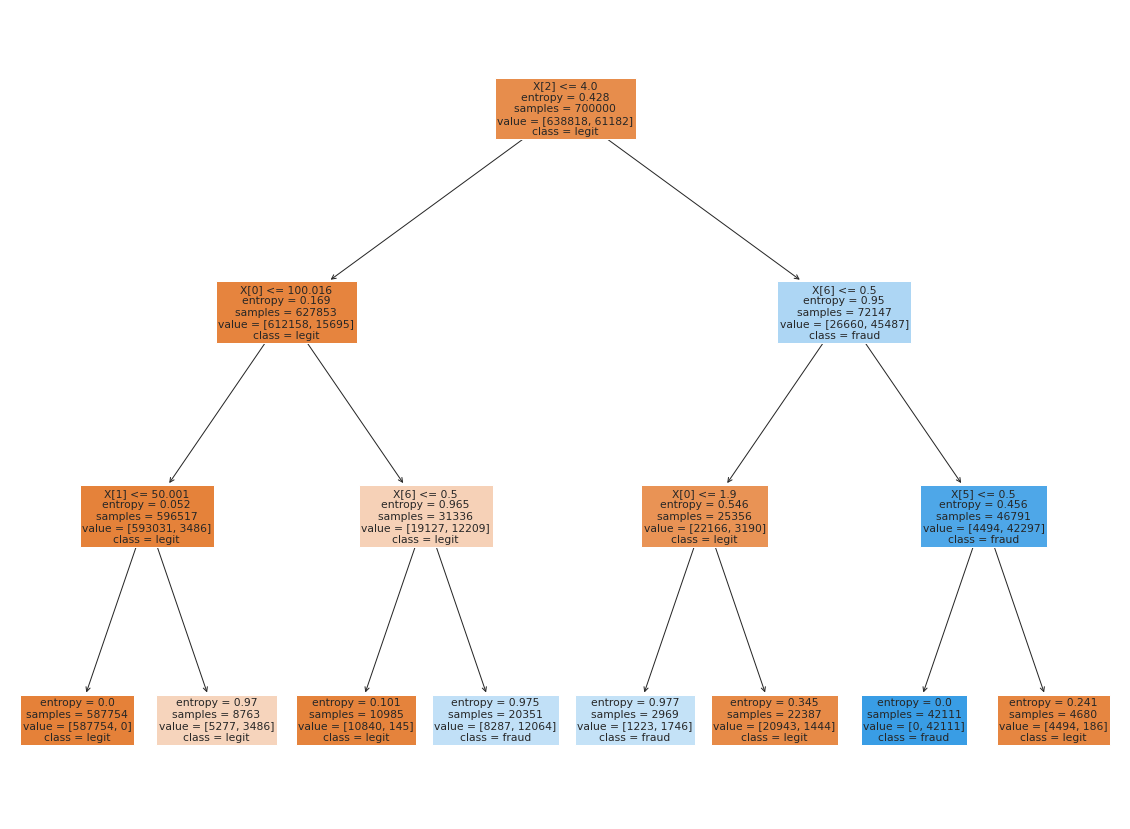

In [ ]:
fig = plt.figure(figsize=(20,15))
tree.plot_tree(dt, class_names=['legit', 'fraud'], filled=True)

In [ ]:
y_pred_dt = dt.predict(x_test)

In [ ]:
y_pred_train_dt = dt.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_dt)

dt_Recall = recall_score(y_test, y_pred_dt)
dt_Precision = precision_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

print(cm)

[[269633   4146]
 [  2300  23921]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_dt)

dt_train_Recall = recall_score(Y, y_pred_train_dt)
dt_train_Precision = precision_score(Y, y_pred_train_dt)
dt_train_f1 = f1_score(Y, y_pred_train_dt)
dt_train_accuracy = accuracy_score(Y, y_pred_train_dt)

print(cm)

[[629308   9510]
 [  5261  55921]]


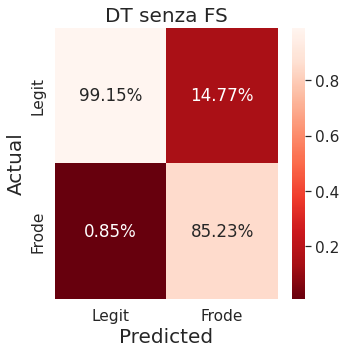

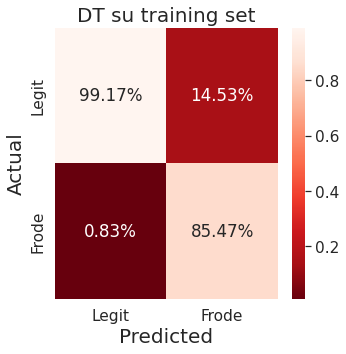

In [ ]:
confusionMatrix(y_test, y_pred_dt,'DT senza FS')
confusionMatrix(Y, y_pred_train_dt,'DT su training set')

In [ ]:
dt_ndf = [(dt_Recall, dt_Precision, dt_f1, dt_accuracy)]

dt_score = pd.DataFrame(data=dt_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
dt_score.insert(0, 'Model', 'dt')
dt_score

,Model,Recall,Precision,F1 Score,Accuracy
0,dt,0.912284,0.852282,0.881263,0.978513


In [ ]:
dt_train_ndf = [(dt_train_Recall, dt_train_Precision, dt_train_f1, dt_train_accuracy)]

dt_train_score = pd.DataFrame(data=dt_train_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
dt_train_score.insert(0, 'Model', 'dt_train')
dt_train_score

,Model,Recall,Precision,F1 Score,Accuracy
0,dt_train,0.914011,0.854656,0.883337,0.978899


In [ ]:
columns = df.iloc[:, 0:7].columns

In [ ]:
feature_imp = pd.Series(dt.feature_importances_, index=columns).sort_values(ascending = False)

In [ ]:
feature_imp

ratio_to_median_purchase_price    0.483984
distance_from_home                0.185889
online_order                      0.165134
distance_from_last_transaction    0.086672
used_pin_number                   0.078322
repeat_retailer                   0.000000
used_chip                         0.000000
dtype: float64

L'importanza delle feature per il Decision Tree mostra chiaramente la motivazione dell'overfitting nonostante una profondità molto bassa. 

Si noti, infatti, che la feature più importante, ovvero `ratio_to_median_purchase_price`, fornisce la maggior parte dell'information gain. Pertanto, è sufficiente considerare anche solo, ad esempio, le prime due feature per ottenere la classificazione.

Inoltre, è interessante osservare che che l'importanza di `ratio_to_median_purchase_price` è indice del fatto che le transazioni fraudolente tendono a variaire molto rispetto all'importo medio.

####**Feature selection al dataset**



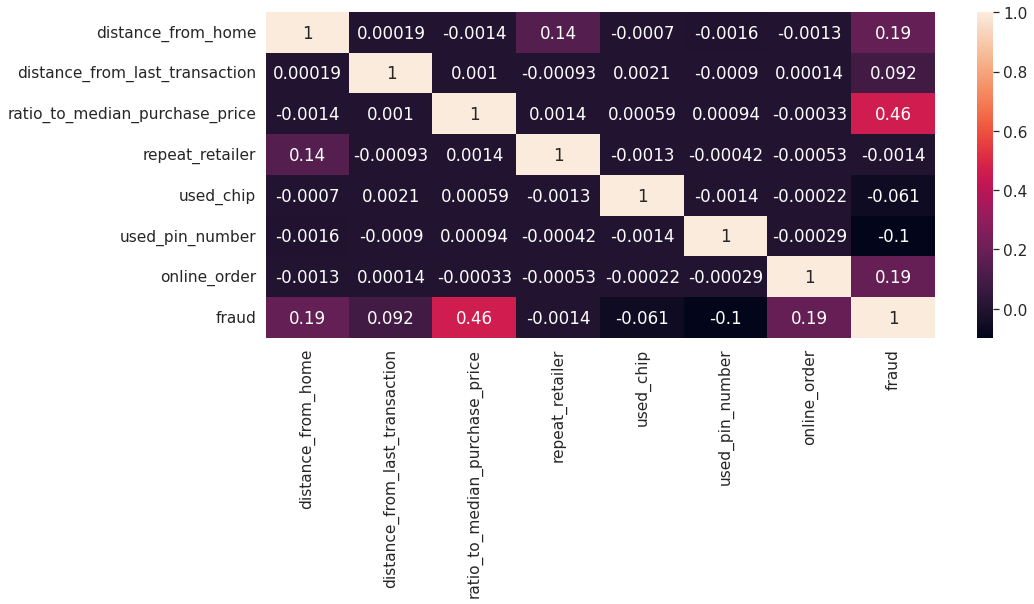

In [ ]:
plt.figure(figsize = (15,6))
sns.heatmap(df.corr(), annot=True)

In [ ]:
df_light = df.drop(['used_chip', 'repeat_retailer', 'used_pin_number'], axis=1)

In [ ]:
df_light.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,online_order,fraud
0,57.877857,0.311140,1.945940,0.0,0.0
1,10.829943,0.175592,1.294219,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,0.0


In [ ]:
X_light = df_light.drop('fraud', axis=1)
Y_light = df_light['fraud']

In [ ]:
X_light, x_test_light, Y_light, y_test_light = train_test_split(X_light, Y_light, stratify=Y_light, test_size = 0.3)

Controlliamo anche in questo caso la curva di Recall vs max_depth

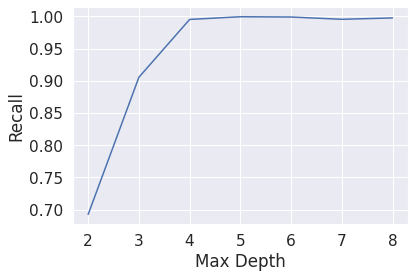

In [ ]:
max_depth_range = np.arange(2, 9)
recall_scores = []

for max_depth in max_depth_range:
    dt1 = tree.DecisionTreeClassifier(max_depth=max_depth)
    dt1.fit(X_light, Y_light)

    y_pred_dt1 = dt1.predict(x_test_light)
    recall = recall_score(y_test_light, y_pred_dt1)
    recall_scores.append(recall)

plt.plot(max_depth_range, recall_scores)
plt.xlabel('Max Depth')
plt.ylabel('Recall')
plt.show()

Consideriamo anche in questo caso una profondità pari a 3.

In [ ]:
dt_fs = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3).fit(X_light, Y_light)

[Text(0.5, 0.875, 'X[2] <= 4.0\nentropy = 0.428\nsamples = 700000\nvalue = [638818, 61182]\nclass = legit'),
 Text(0.25, 0.625, 'X[0] <= 100.014\nentropy = 0.169\nsamples = 627801\nvalue = [612090, 15711]\nclass = legit'),
 Text(0.125, 0.375, 'X[1] <= 50.029\nentropy = 0.052\nsamples = 596623\nvalue = [593108, 3515]\nclass = legit'),
 Text(0.0625, 0.125, 'entropy = 0.0\nsamples = 587749\nvalue = [587749, 0]\nclass = legit'),
 Text(0.1875, 0.125, 'entropy = 0.969\nsamples = 8874\nvalue = [5359, 3515]\nclass = legit'),
 Text(0.375, 0.375, 'X[3] <= 0.5\nentropy = 0.966\nsamples = 31178\nvalue = [18982, 12196]\nclass = legit'),
 Text(0.3125, 0.125, 'entropy = 0.104\nsamples = 10810\nvalue = [10662, 148]\nclass = legit'),
 Text(0.4375, 0.125, 'entropy = 0.976\nsamples = 20368\nvalue = [8320, 12048]\nclass = fraud'),
 Text(0.75, 0.625, 'X[3] <= 0.5\nentropy = 0.951\nsamples = 72199\nvalue = [26728, 45471]\nclass = fraud'),
 Text(0.625, 0.375, 'X[0] <= 100.037\nentropy = 0.543\nsamples = 2532

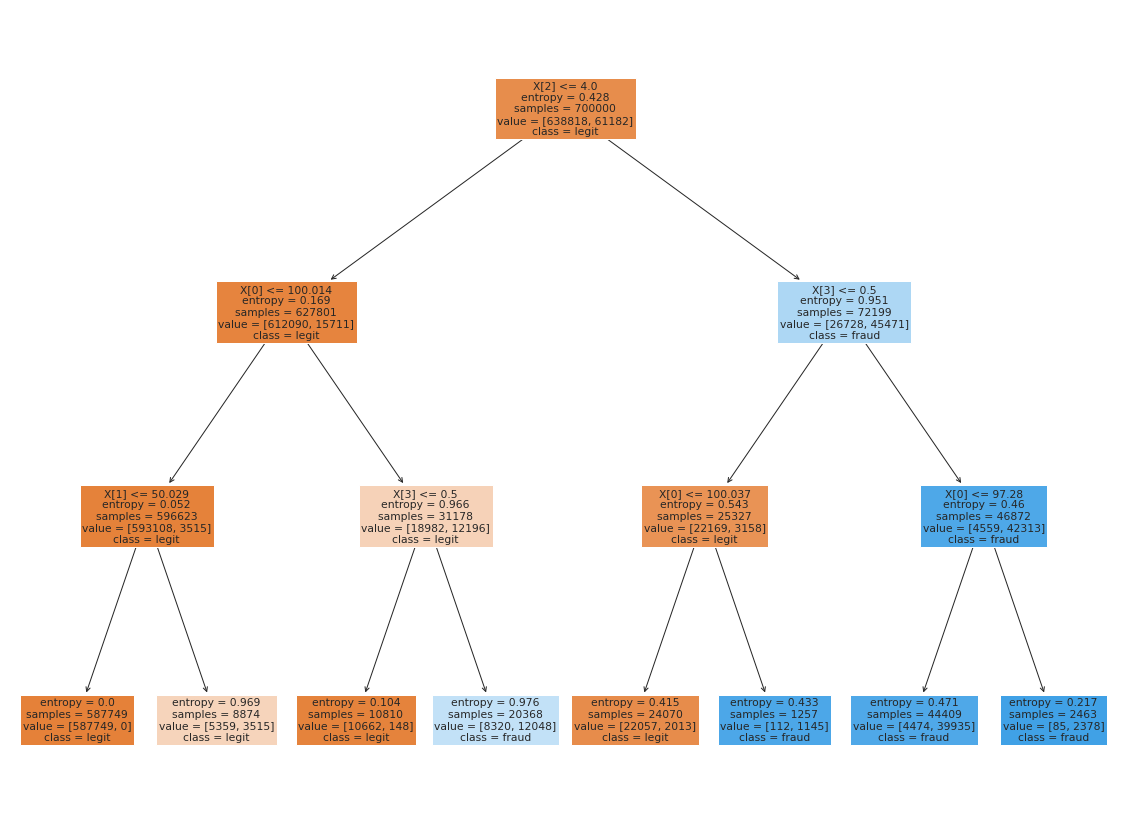

In [ ]:
fig = plt.figure(figsize=(20,15))
tree.plot_tree(dt_fs, class_names=['legit', 'fraud'], filled=True)

In [ ]:
y_pred_dt_fs = dt_fs.predict(x_test_light)

In [ ]:
y_pred_train_dt_fs = dt_fs.predict(X_light)

In [ ]:
cm = confusion_matrix(y_test_light, y_pred_dt_fs)

dt_fs_Recall = recall_score(y_test_light, y_pred_dt_fs)
dt_fs_Precision = precision_score(y_test_light, y_pred_dt_fs)
dt_fs_f1 = f1_score(y_test_light, y_pred_dt_fs)
dt_fs_accuracy = accuracy_score(y_test_light, y_pred_dt_fs)

print(cm)

[[268232   5547]
 [  2475  23746]]


In [ ]:
cm = confusion_matrix(Y_light, y_pred_train_dt_fs)

dt_fs_train_Recall = recall_score(Y_light, y_pred_train_dt_fs)
dt_fs_train_Precision = precision_score(Y_light, y_pred_train_dt_fs)
dt_fs_train_f1 = f1_score(Y_light, y_pred_train_dt_fs)
dt_fs_train_accuracy = accuracy_score(Y_light, y_pred_train_dt_fs)

print(cm)

[[625827  12991]
 [  5676  55506]]


In [ ]:
dt_fs_ndf = [(dt_fs_Recall, dt_fs_Precision, dt_fs_f1, dt_fs_accuracy)]

dt_fs_score = pd.DataFrame(data=dt_fs_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
dt_fs_score.insert(0, 'Model', 'dt_fs')
dt_fs_score

,Model,Recall,Precision,F1 Score,Accuracy
0,dt_fs,0.90561,0.810637,0.855496,0.97326


In [ ]:
dt_fs_train_ndf = [(dt_fs_train_Recall, dt_fs_train_Precision, dt_fs_train_f1, dt_fs_train_accuracy)]

dt_fs_train_score = pd.DataFrame(data=dt_fs_train_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
dt_fs_train_score.insert(0, 'Model', 'dt_train')
dt_fs_train_score

,Model,Recall,Precision,F1 Score,Accuracy
0,dt_train,0.907228,0.810342,0.856052,0.973333


###**Confronto Performance**

In [ ]:
predictions = pd.concat([dt_score, dt_fs_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
0,dt,0.912284,0.852282,0.881263,0.978513
1,dt_fs,0.905610,0.810637,0.855496,0.973260


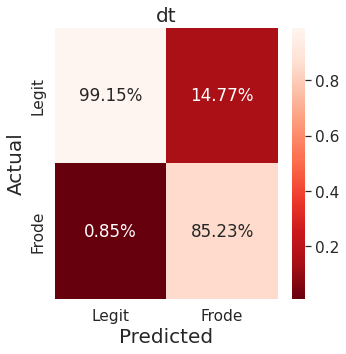

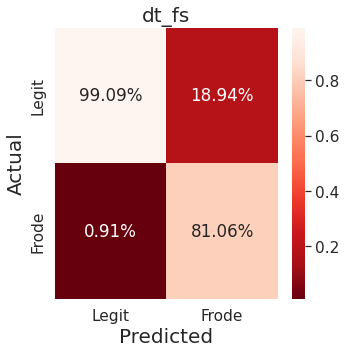

In [ ]:
confusionMatrix(y_test, y_pred_dt,'dt')
confusionMatrix(y_test_light, y_pred_dt_fs,'dt_fs')

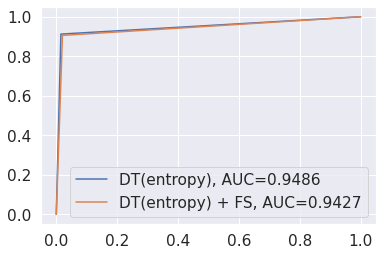

In [ ]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_dt)
auc = round(metrics.roc_auc_score(y_test, y_pred_dt), 4)
plt.plot(fpr,tpr,label="DT(entropy), AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_light, y_pred_dt_fs )
auc = round(metrics.roc_auc_score(y_test_light, y_pred_dt_fs ), 4)
plt.plot(fpr,tpr,label="DT(entropy) + FS, AUC="+str(auc))

#add legend
plt.legend()

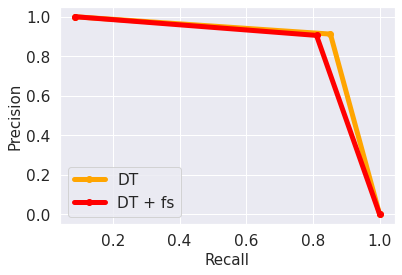

In [ ]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_dt)
plt.plot(precision, recall, marker='o', label='DT',color='orange',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test_light, y_pred_dt_fs)
plt.plot(precision, recall, marker='o', label='DT + fs',color='red',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

###Conclusioni

Questa ulteriore sperimentazione conferma la tendenza del dataset a portare i modelli al sovradimensionamento. 
Inoltre, come ci si aspettava, la feature selection riduce leggermente l'area sottesa dalla curva di precision-recall.

##**CLUSTERING SU DATASET PER CLASSIFICAZIONE BINARIA**

Nel dataset in esame, la classe delle transazioni fraudolente è nettamente distinta dalla classe delle transazioni legali?
In altre parole, è giusto aspettarsi due cluster da questo database?

Per definizione in una classificazione binaria si hanno a disposizione due classi. Se, applicando un algoritmo di clustering, si rilevano più di due classi è verosimile che i dati _raw_, così come si presentano, non siano adatti alla classificazione binaria.

In questa sezione si applica un algoritmo di clustering sul dataset in esame per studiarne la topologia dei dati, consapevoli del fatto che il KMeans è un algoritmo di clustering piuttosto che di classificazione, progettato per l'identificazione di pattern e strutture nei dati.

In [6]:
!pip install kneed # To install only knee-detection algorithm
!pip install kneed[plot] # To also install plotting functions for quick visualizations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

###**Individuare il numero di cluster**

Il metodo comunemente utilizzato per valutare il numero di cluster più appropriato per il dataset considerato è il *metodo del gomito*.

Esso consiste nell'applicare il kmeans diverse volte, incrementando il k (numero di cluster) ad ogni iterata e registrando il SSE (somma dell'errore quadratico, o inerzia).

Applichiamo tale metodo al dataset privato delle label così da osservare se, anche senza etichette, il modello riconosce nel dataset due cluster differenti corrispondenti alle due tipologie di transizioni.



In [105]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Progetto ICON/datasets/card_transdata.csv')

In [72]:
X = data.drop("fraud", axis=1)
Y = data["fraud"]

In [73]:
X, x_test, Y, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.3)

In [74]:
n_clusters_range = range(1, 6)
inertias = []
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

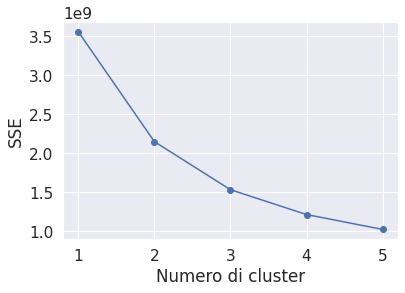

In [75]:
plt.plot(n_clusters_range, inertias, marker='o')
plt.xlabel("Numero di cluster")
plt.ylabel("SSE")
plt.show()

In [76]:
kl = KneeLocator(range(1, 6), inertias, curve="convex", direction="decreasing")
print('Il k ottimale è: ' + str(kl.elbow))

Il k ottimale è: 2


Il metodo del gomito indica `k=2` come miglior numero di cluster, ovvero come miglior compromesso tra numero di cluster ed errore quadratico. 

In [78]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

KMeans(n_clusters=2)

In [90]:
y_pred = kmeans.predict(x_test)

In [98]:
rec = recall_score(y_test, y_pred)
print("Recall: ", rec)

Recall:  0.08512261164715304


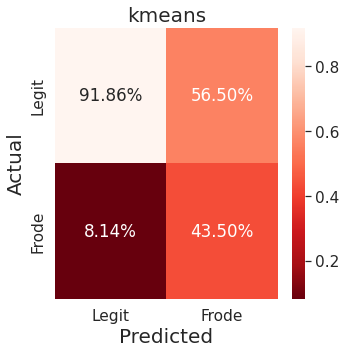

In [93]:
confusionMatrix(y_test, y_pred,'kmeans')

I risultati indicano delle pessime prestazioni di classificazione delle frodi, inferiori ad un classificatore casuale. Il modello riesce a riconoscere le transazioni legali, ma si lascia sfuggire gran parte delle transazioni fraudolente.  

####**Applicazione della PCA per la rappresentazione bidimensionale dei cluster**

In [117]:
from sklearn.decomposition import PCA
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Progetto ICON/datasets/card_transdata.csv')


In [118]:
X = data.drop("fraud", axis=1)
Y = data["fraud"]
X, x_test, Y, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.3)


In [113]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

In [114]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_reduced)

KMeans(n_clusters=2)

In [115]:
labels = kmeans.labels_

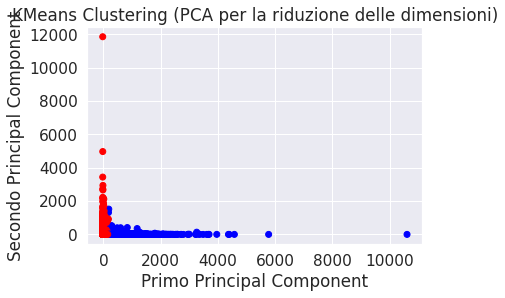

In [116]:
colors = ['red', 'blue']
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=[colors[lbl] for lbl in labels])
plt.title("KMeans Clustering (PCA per la riduzione delle dimensioni)")
plt.xlabel("Primo Principal Component")
plt.ylabel("Secondo Principal Component")
plt.show()



In [123]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_reduced)

labels = kmeans.labels_

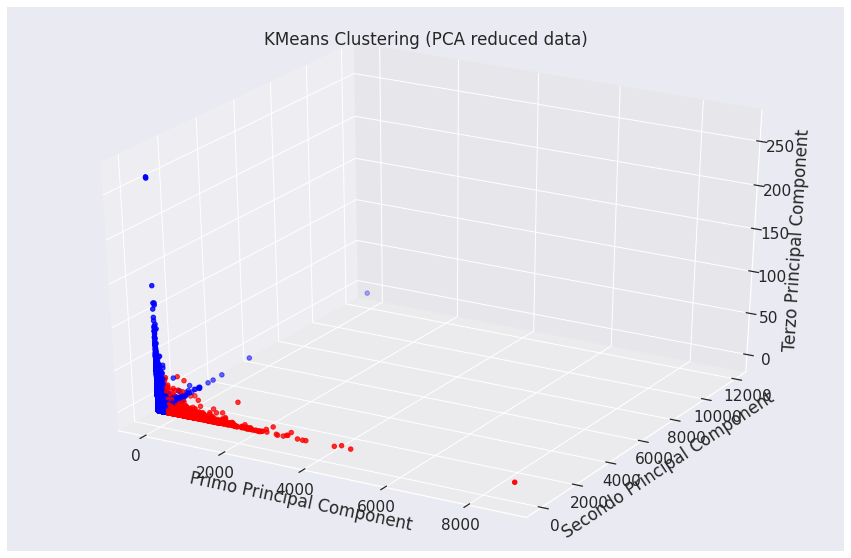

In [128]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'blue']
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=[colors[lbl] for lbl in labels])
ax.set_title("KMeans Clustering (PCA reduced data)")
ax.set_xlabel("Primo Principal Component")
ax.set_ylabel("Secondo Principal Component")
ax.set_zlabel("Terzo Principal Component")
plt.show()

###**Conclusioni**

In generale, è preferibile utilizzare appositi algoritmi per task di classificazione. Ciononostante, a presindere dai risultati, si è ritenuto interessante analizzare il comportamento del KMeans su un dataset i cui esempi non sono disposti in cluster ben definiti nello spazio, anche a conferma delle difficoltà riscontrate durante le prove di classificazione.